© 2025 Vanargo · Лицензия: MIT. См. файл `LICENSE` в корне репозитория.

# --- Fairness & Explainability: setup --- #

**Цель ноутбука.** Оценить *справедливость* и качество модели, найти компромиссные пороги (в т.ч. пост-процессинг с FairLearn), проверить калибровку вероятностей по группам и объяснить поведение модели (SHAP или альтернативы).

1. Fairness-метрики: selection rate, TPR/FPR, precision, F1, dem. parity / equalized odds.
2. Пороговая оптимизация: скан порогов, Pareto (качество <-> разрыв справедливости), 'ThresholdOptimizer'.
3. Калибровка по группам: reliability curves.
4. Explainability: глобально (SHAP / permutation importance), локально (кейсы).

In [100]:
# --- Project paths bootstrip --- #

# imports & paths #
%load_ext autoreload
%autoreload 2

import sys
import scipy.sparse as sp
from pathlib import Path

# предоставление Jupyter доступа к модулям из корня проекта #
ROOT = Path.cwd()
while not any((ROOT / m).exists() for m in ('.git', 'pyproject.toml', 'README.md')) and ROOT.parent != ROOT:
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from paths import ROOT, DATA_DIR, RAW_DIR, INT_DIR, PROC_DIR, ART_DIR, REPORTS_DIR, MODELS_DIR, NB_DIR
print(f'[paths] ROOT = {ROOT}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[paths] ROOT = C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02


In [101]:
# --- Fairness plotting utils & output dirs --- #
import matplotlib.pyplot as plt

# попытка взять стандартные пути из проекта; иначе - fallbacks #
try:
    from paths import REPORTS_DIR as _REPORTS_DIR, ART_DIR as _ART_DIR
except Exception:
    _REPORTS_DIR = Path('data') / 'reports'
    _ART_DIR = Path('data') / 'artifacts'

REPORTS_DIR = globals().get('REPORTS_DIR', _REPORTS_DIR)
ART_DIR = globals().get('ART_DIR', _ART_DIR)

FIG_DIR_03 = REPORTS_DIR / 'figures_03'
FIG_DIR_03.mkdir(parents=True, exist_ok=True)

def save_fig(fig=None, name='plot.png', dpi=200):
    """
    Унифицированное сохранение графика в reports/figures_03/.
    Если передан fig_or_none=None, сохранится текущая фигура plt.gcf().
    """
    p = FIG_DIR_03 / name
    plt.savefig(p, dpi=dpi, bbox_inches='tight')
    print(f'[ok] saved: {p}')
    return p


In [102]:
# --- Fairness & Explainability: setup --- #

import warnings, logging, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

import shap
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, precision_recall_fscore_support
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline

from fairlearn.postprocessing import ThresholdOptimizer
from pandas.api.types import is_categorical_dtype

import inspect
import joblib, xgboost as xgb
from IPython import get_ipython
from pathlib import Path
from sklearn.inspection import permutation_importance
from joblib import load
from shutil import copy2
from scipy import sparse
import re
import itertools

from sklearn.exceptions import InconsistentVersionWarning

# тихие режимы #
logging.getLogger('lightgbm').setLevel(logging.ERROR)
logging.getLogger('xgboost').setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*LightGBM binary classifier.*TreeExplainer.*')
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*Glyph .* missing from current font.*')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'DejaVu Sans'
rng = np.random.default_rng(42)

# подключение fairlearn (fairness-метрики и пост-процессинг) #
try:
    from fairlearn.metrics import (
        MetricFrame,
        selection_rate,
        demographic_parity_difference,
        demographic_parity_ratio,
        equalized_odds_difference
    )
    from fairlearn.postprocessing import ThresholdOptimizer
    FAIRLEARN_OK = True
except Exception as e:
    FAIRLEARN_OK = False
    warnings.warn('Fairlearn не найден - разделы MetricFrame/ThresholdOptimizer будут пропущены: {e}')

# подключение SHAP #
try:
    import shap
    SHAP_OK = True
except Exception:
    SHAP_OK = False
    warnings.warn('shap не найден - блоки с SHAP будут пропущены.')

# кривые калибровки #
from sklearn.calibration import calibration_curve

# общие настройки визуализации и воспроизводимости #
SEED = 42
rng = np.random.default_rng(SEED)

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True

# умный выбор директорий с артефактами и моделями #
def _first_existing(paths, fallback: Path):
    """Возвращает первый существующий путь из списка,
    иначе создает/возвращает fallback"""
    for p in paths:
        if p.exists():
            return p
    fallback.mkdir(parents=True, exist_ok=True)
    return fallback

CANDIDATE_ART_DIRS =    [ART_DIR]
CANDIDATE_MODEL_DIRS =  [MODELS_DIR]

ART_DIR = _first_existing(CANDIDATE_ART_DIRS, Path('artifacts'))
MODELS_DIR = _first_existing(CANDIDATE_MODEL_DIRS, Path('models'))

print('ART_DIR  =', ART_DIR.resolve())
print('MODELS_DIR  =', MODELS_DIR.resolve())
print('FAIRLEARN_OK:', FAIRLEARN_OK, '| SHAP_OK', SHAP_OK)

ART_DIR  = C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts
MODELS_DIR  = C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\models
FAIRLEARN_OK: True | SHAP_OK True


In [103]:
# --- Notebook preamble: silence & style --- #

# тихие логгеры #
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('numba').setLevel(logging.ERROR)

# красивые графики и кириллица без предупреждений о 'glyphs' #
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# адресные централизованные фильтры предупреждений #
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*Numpy global RNG was seeded.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*is_categorical_dtype is deprecated.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*pandas.*allow_gtml.*')
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*FixedFormatter should only be used with FixedLocator.*')

# полностью скрыть DeprecationWarning #
warnings.filterwarnings('ignore', category=DeprecationWarning)

# без спама от Jupyter магии autereload #
ip = get_ipython()
if ip:
    try:
        ip.run_line_magic('load_ext', 'autoreload')
    except Exception:
        pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
model_path = MODELS_DIR / 'lgb_best.joblib'
if 'A' in globals():
    model, model_path = A['model']
    lgb_best = model
    print('Loaded model:', model_path)
else:
    lgb_best = None
    print('[warn] Артефакты еще не загружены. Выполните ячейку с unified loader.')

Loaded model: c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\models\LGBM_best.joblib


In [105]:
# --- Refresh fairlearn availability flags --- #

try:
    import fairlearn
    from fairlearn.metrics import (MetricFrame, selection_rate,
                                   demographic_parity_difference)
    from fairlearn.postprocessing import ThresholdOptimizer
    FAIRLEARN_OK = True
    THRESH_OPT_OK = True
    print('fairlearn OK:', fairlearn.__version__)
except Exception as e:
    FAIRLEARN_OK = False
    THRESH_OPT_OK = False
    print('[fairlearn] все еще недоступен. fairness-блоки будут пропущены: {e!r}')

fairlearn OK: 0.12.0


In [106]:
# --- Paths & unified artifact loader --- #
from pathlib import Path
import json, joblib, numpy as np, pandas as pd

# найти корень проекта
ROOT = Path.cwd()
while not any((ROOT/p).exists() for p in ('.git','pyproject.toml','README.md')) and ROOT.parent != ROOT:
    ROOT = ROOT.parent

ART_DIR    = ROOT / 'data' / 'artifacts'
MODELS_DIR = ROOT / 'data' / 'models'
NB_ART_DIR = ROOT / 'notebooks' / 'data' / 'artifacts'  # fallback на старые архивы

def _pick_file(name_variants, bases):
    for base in bases:
        for nm in name_variants:
            p = base / nm
            if p.exists():
                if base == NB_ART_DIR:
                    print(f"[warn] fallback path in use: {p}")
                return p
    return None

def load_model():
    p = _pick_file(['model_best.joblib','lgb_best.joblib','LGBM_best.joblib'], [MODELS_DIR])
    if p is None:
        raise FileNotFoundError("Модель не найдена в data/models: model_best.joblib|lgb_best.joblib|LGBM_best.joblib")
    return joblib.load(p), p

def load_feature_names():
    p = _pick_file(['feature_names.npy','feature_names.json','feature_names.txt','feature_names.csv'], [ART_DIR, NB_ART_DIR])
    if p is None:
        return None, None
    if p.suffix == '.npy':
        return np.load(p, allow_pickle=True).tolist(), p
    if p.suffix == '.json':
        return json.loads(p.read_text(encoding='utf-8')), p
    if p.suffix == '.txt':
        return p.read_text(encoding='utf-8').splitlines(), p
    if p.suffix == '.csv':
        return pd.read_csv(p, header=None)[0].tolist(), p

def load_X_test_enc():
    p = _pick_file(['X_test_enc.npy','X_test_enc.npz','X_test_enc.parquet'], [ART_DIR, NB_ART_DIR])
    if p is None:
        return None, None
    if p.suffix == '.npy':
        return np.load(p, allow_pickle=False), p
    if p.suffix == '.npz':
        z = np.load(p, allow_pickle=False)
        return z.get('arr_0', None), p
    if p.suffix == '.parquet':
        return pd.read_parquet(p), p

def load_sensitive():
    p = _pick_file(['X_test_sensitive.csv','X_test_sensitive.parquet'], [ART_DIR, NB_ART_DIR])
    if p is None:
        return None, None
    return (pd.read_csv(p) if p.suffix=='.csv' else pd.read_parquet(p), p)

def load_results():
    p1 = _pick_file(['results_df.csv','results_df.xlsx'], [ART_DIR, NB_ART_DIR])
    p2 = _pick_file(['test_groups.csv','test_groups.xlsx'], [ART_DIR, NB_ART_DIR])
    df1 = pd.read_csv(p1)  if p1 and p1.suffix=='.csv'  else (pd.read_excel(p1)  if p1 else None)
    df2 = pd.read_csv(p2)  if p2 and p2.suffix=='.csv'  else (pd.read_excel(p2)  if p2 else None)
    return df1, p1, df2, p2

def load_y():
    y_true  = _pick_file(['y_true_test.npy','y_test.npy'], [ART_DIR, NB_ART_DIR])
    y_proba = _pick_file(['y_proba_best.npy','y_score.npy'], [ART_DIR, NB_ART_DIR])
    y_pred  = _pick_file(['y_pred_best.npy','y_pred_050.npy'], [ART_DIR, NB_ART_DIR])
    return (
        (np.load(y_true)  if y_true  else None),
        (np.load(y_proba) if y_proba else None),
        (np.load(y_pred)  if y_pred  else None),
        {'y_true': y_true, 'y_proba': y_proba, 'y_pred': y_pred}
    )

def load_artifacts_summary():
    model, model_p = load_model()
    ftrs, f_p      = load_feature_names()
    Xenc,  X_p     = load_X_test_enc()
    sens,  s_p     = load_sensitive()
    resdf, res_p, groups, grp_p = load_results()
    y_true, y_proba, y_pred, y_ps = load_y()
    print("ART_DIR   =", ART_DIR.resolve())
    print("MODELS_DIR=", MODELS_DIR.resolve())
    return {
        'model': (model, model_p),
        'feature_names': (ftrs, f_p),
        'X_test_enc': (Xenc, X_p),
        'sensitive': (sens, s_p),
        'results_df': (resdf, res_p),
        'test_groups': (groups, grp_p),
        'y_true': (y_true, y_ps['y_true']),
        'y_proba': (y_proba, y_ps['y_proba']),
        'y_pred': (y_pred, y_ps['y_pred']),
    }

In [107]:
# --- Единый вызов после ячейки инициализации --- #

A = load_artifacts_summary()

model, model_path                 = A['model']
feature_names, feature_names_path = A['feature_names']
X_test_enc, X_test_enc_path       = A['X_test_enc']
X_test_sensitive, sens_path       = A['sensitive']
results_df, results_path          = A['results_df']
test_groups, groups_path          = A['test_groups']
y_true, y_true_path               = A['y_true']
y_proba, y_proba_path             = A['y_proba']
y_pred, y_pred_path               = A['y_pred']

print('[ok] model:', model_path.name)
for name, p in [('feature_names',feature_names_path),
                ('X_test_enc',X_test_enc_path),
                ('sensitive',sens_path),
                ('results_df',results_path),
                ('test_groups',groups_path),
                ('y_true',y_true_path),
                ('y_proba',y_proba_path),
                ('y_pred',y_pred_path)]:
    print(f"[{'ok' if p else 'miss'}] {name}:", (p.name if p else None))

# алиасы под старые имена для совместимости #
X_test_sens = X_test_sensitive
y_true_test = y_true
y_proba_best = y_proba
y_pred_best = y_pred

ART_DIR   = C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts
MODELS_DIR= C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\models
[ok] model: LGBM_best.joblib
[ok] feature_names: feature_names.npy
[ok] X_test_enc: X_test_enc.npy
[ok] sensitive: X_test_sensitive.csv
[ok] results_df: results_df.csv
[ok] test_groups: test_groups.csv
[ok] y_true: y_true_test.npy
[ok] y_proba: y_proba_best.npy
[ok] y_pred: y_pred_best.npy


# --- Загрузка артефактов из 02_modeling.ipynb --- #

Берем сохраненные артефакты из 'notebooks/artifacts':
1. *'y_true_test.npy'*, *'y_pred_best.npy'*, *'y_proba_best.npy'*.
2. *'X_test_sesitive.csv'*.
3. *'feature_names_ater_preproc.csv'*.
4. *'results_df.csv'*.

Эти данные уже подготовлены и соответствуют лучшей модели.
Они нужны для оценки fairness, подбора порогов и объяснимости.

In [108]:
# sanity-report из единого загрузчика #
assert 'A' in globals(), 'Выполните ячейку с unified loader'

model, model_path = A['model']
feature_names, feature_names_path = A['feature_names']
X_test_sens, _ = A['sensitive']
results_df, _ = A['results_df']
y_true_test, _ = A['y_true']
y_proba_best, _ = A['y_proba']
y_pred_best, _ = A['y_pred']

print('Загружено:')
print('y_true_test  :', y_true_test.shape)
print('y_pred_best  :', y_pred_best.shape)
print('y_proba_best  :', y_proba_best.shape)
print('X_test_sens  :', X_test_sens.shape)
print('feature_names  :', len(feature_names) if feature_names is not None else None)
print('results_df  :', results_df.shape if results_df is not None else None)

Загружено:
y_true_test  : (9769,)
y_pred_best  : (9769,)
y_proba_best  : (9769,)
X_test_sens  : (9769, 4)
feature_names  : 115
results_df  : (7, 6)


In [109]:
# --- Загрузка лучшей модели --- #

model, model_path = A['model']
best_model = model
bst = None
print('Загружена модель:', model_path)

Загружена модель: c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\models\LGBM_best.joblib


# --- sanity-check: размеры, NaN, распределение y_proba --- #

Проверяем:
1. Равную длину *'y_true_test'*, *'y_pred_best'*, *'y_proba_best'*, *'X_test_sens'*.
2. Отсутствие NaN в *'y_proba_best'* и корректный диапазон [0,1].
3. Быструю гистограмму *'y_proba_best'*.
4. Базовый pos_rate (t = 0.5) по ключевым группам ('sex', 'race', 'age_group', если есть).

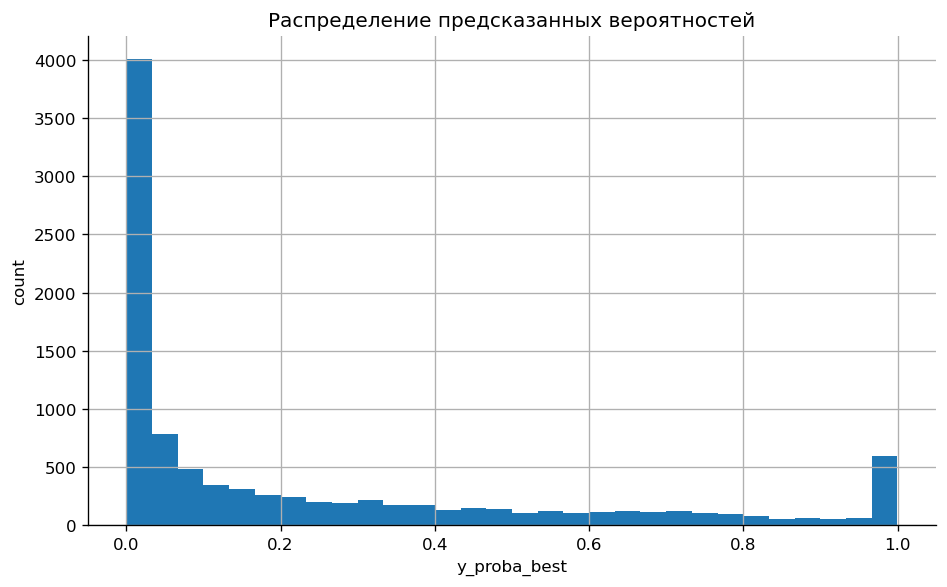

[sex] selection rate @ t = 0.5:
sex
Male      0.259722
Female    0.079659
Name: y_pred_05, dtype: float64 

[race] selection rate @ t = 0.5:
race
Asian-Pac-Islander    0.230263
White                 0.213584
Other                 0.086957
Black                 0.082627
Amer-Indian-Eskimo    0.076923
Name: y_pred_05, dtype: float64 

[age_group] selection rate @ t = 0.5:
age_group
46-65    0.316544
26-45    0.217785
65+      0.155125
18-25    0.007110
Name: y_pred_05, dtype: float64 



In [110]:
# --- sanity-check: размеры, NaN, распределение y_proba --- #

# проверка присутствия артефактов из A #
assert all(k in globals() for k in ['y_true_test', 'y_pred_best', 'y_proba_best', 'X_test_sens']), 'Нет алиасов от unified loader.'

# согласованность размеров #
n = len(y_true_test)
assert len(y_pred_best) == n and len(y_proba_best) == n, 'Длины y_* не совпадают'
assert len(X_test_sens) == n, 'Длина X_test_sens не совпадает с y'

# NaN и допустимый диапазон #
assert np.isfinite(y_proba_best).all(), 'Есть NaN/Inf в y_proba_best'
assert (y_proba_best >= 0).all() and (y_proba_best <= 1).all(), 'y_proba_best вне [0,1]'

# гистограмма вероятностей #
plt.figure()
plt.hist(y_proba_best, bins=30)
plt.xlabel('y_proba_best')
plt.ylabel('count')
plt.title('Распределение предсказанных вероятностей')
plt.tight_layout()
plt.show()

# базовый pos_rate по группам (t = 0.5) #
t = 0.5
y_pred_05 = (y_proba_best >= t).astype('int8')

pred_ser = pd.Series(y_pred_05, index=X_test_sens.index, name='y_pred_05')

for gcol in [c for c in ['sex', 'race', 'age_group'] if c in X_test_sens.columns]:
    grp = X_test_sens[gcol].fillna('NA')
    rates = pred_ser.groupby(grp).mean().sort_values(ascending=False)
    print(f'[{gcol}] selection rate @ t = 0.5:')
    print(rates, '\n')

# --- Определение чувствительных признаков и групп --- #

Берем кандидатов ['sex', 'race', 'age_group'], оставляем только реаьно присутствующие в *'X_test_sens'*. Для каждого признака фиксируем список групп (без NaN), порядок - осмысленный (для *'age_group'* задаем категориальный порядок)

In [111]:
# --- Чувствительные признаки и группы --- #

# гарантия наличия X_test_sens из unified loader #
assert 'X_test_sens' in globals(), 'X_test_sens должен быть из unified loader.'

CAND_SENSITIVE = ['sex', 'race', 'age_group']
SENSITIVE = [c for c in CAND_SENSITIVE if c in X_test_sens.columns]
print('Используем SENSITIVE:', SENSITIVE)

# осмысленный порядок для age_group #
if 'age_group' in SENSITIVE:
    desired_order = ['18-25', '26-45', '46-65', '65+']
    try:
        X_test_sens['age_group'] = pd.Categorical(
            X_test_sens['age_group'],
            categories=desired_order,
            ordered=True
        )
    except Exception as e:
        print('Не удалось задать порядок для age_group:', e)

# собираем уникальные значения по каждой чувствительной переменной #
GROUP_VALUES = {}
for col in SENSITIVE:
    vals = (
        X_test_sens[col]
        .dropna()
        .unique()
        .tolist()
    )
    if (col == 'age_group') and hasattr(X_test_sens[col], 'cat'):
        vals = [v for v in X_test_sens[col].cat.categories if v in set(X_test_sens[col].dropna())]
        GROUP_VALUES = list(vals)

# отчет по наличию групп и их размерам #
for col in SENSITIVE:
    print(f'\n[{col}] группы и размерности:')
    df_sizes = (
        X_test_sens[col]
        .value_counts(dropna=False)
        .rename_axis('group')
        .reset_index(name='n')
        .assign(share=lambda d: d['n'] / len(X_test_sens))
    )
    display(df_sizes)

print('\nGROUP_VALUES =', GROUP_VALUES)

# главная чувсвительная переменная  #
PRIMARY_SENS = SENSITIVE[0] if SENSITIVE else None
print('PRIMARY_SENS:', PRIMARY_SENS)

Используем SENSITIVE: ['sex', 'race', 'age_group']

[sex] группы и размерности:


,group,n,share
0,Male,6480,0.663323
1,Female,3289,0.336677



[race] группы и размерности:


,group,n,share
0,White,8348,0.854540
1,Black,944,0.096632
2,Asian-Pac-Islander,304,0.031119
3,Amer-Indian-Eskimo,104,0.010646
4,Other,69,0.007063



[age_group] группы и размерности:


,group,n,share
0,26-45,4858,0.497287
1,46-65,2581,0.264203
2,18-25,1969,0.201556
3,65+,361,0.036954



GROUP_VALUES = ['18-25', '26-45', '46-65', '65+']
PRIMARY_SENS: sex


# --- Базовая линия: метрики на общем пороге (0.5) --- #

Считаем Accuracy, F1, Precision, Recall, ROC-AUC на всем тестовом наборе при пороге 0.5.

In [112]:
# Базовые метрики на t = 0.5 #

# бинарные предсказания при пороге 0.5 #
y_pred_05 = (y_proba_best >= 0.5).astype(int)

base_metrics = {
    'accuracy': accuracy_score(y_true_test, y_pred_05),
    'f1': f1_score(y_true_test, y_pred_05),
    'precision': precision_score(y_true_test, y_pred_05, zero_division=0),
    'roc_auc': roc_auc_score(y_true_test, y_proba_best)
}

print('Базовые метрики (t = 0.5):')
display(pd.DataFrame([base_metrics]).round(4))

Базовые метрики (t = 0.5):


,accuracy,f1,precision,roc_auc
0,0.8789,0.7238,0.7969,0.9321


# --- Fairness по группам при t = 0.5 --- #

Считаем метрики по каждой чувствительной переменной:
1. *'selection_rate'* (доля позитивных предсказаний).
2. *'recall'* (TPR), *'FPR'*, *'precision'*, *'F1'*.
3. *'demographic_parity_difference'* / *'demographic_parity_ratio'*.
4. *'equalized_odds_difference'*.

In [113]:
# --- Групповые fairness-метрики при t = 0.5 --- #

t = 0.5
y_pred = (y_proba_best >= t).astype('int8')

def _prec(y_true, y_pred): return precision_score(y_true, y_pred, zero_devision=0)
def _rec(y_true, y_pred): return recall_score(y_true, y_pred, zero_division=0)
def _f1(y_true, y_pred): return f1_score(y_true, y_pred, zero_division=0)
def _acc(y_true, y_pred): return accuracy_score()

# --- Пороговая кривая и Pareto: качество vs Demographic Parity --- #

Перебираем пороги *'t ∈ [0.05; 0.95]'* с шагом 0.01. Для каждого t считаем:
1. общие метрики (accuracy, f1, precision, recall, roc_auc).
2. *'dp_diff_max'* - максимальный разрыв demographic parity среди всех чувствительных признаков.
3. *'eqodds_diff_max'* - максимальный разрыв equalized odds (через max по TPR/FPR).

In [114]:
# --- Пороговый скан + Pareto + выбор t* + сохранение графиков --- #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.api.types import is_categorical_dtype
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

# заполнение NaN в sens-серии #
def _sens_fill(s: pd.Series) -> pd.Series:
    s = s.copy()
    if is_categorical_dtype(s):
        if 'NA' not in s.cat.categories:
            s = s.cat.add_categories(['NA'])
        return s.fillna('NA')
    else:
        return s.fillna('NA')

# какие чувствительные признаки есть в X_test_sens #
sens_cols = [c for c in ['sex', 'race', 'age_group'] if c in X_test_sens.columns]
if len(sens_cols) == 0:
    raise RuntimeError('В X_test_sens не найдено ни одного из ожидаемых чувствительных признаков: sex/race/age_group.')

# ensure y_true_test / y_proba_best присутствуют #
assert 'y_true_test' in globals() and 'y_proba_best' in globals(), 'Нужны y_true_test и y_proba_best из 02_modeling.'

# Формирование пороговой таблицы #
# Столбцы: t, f1, precision, recall, accuracy, auc, dp_diff_max, eod_diff_max #
ts = np.round(np.arange(0.05, 0.95, 0.01), 2)
rows = []
for t in ts:
    # делаем Series с тем же индексом, что у X_test_sens — ТАК можно использовать groupby
    y_pred_t = pd.Series((y_proba_best >= t).astype(int), index=X_test_sens.index)

    # базовые метрики
    m_f1 = f1_score(y_true_test, y_pred_t, zero_division=0)
    m_pr = precision_score(y_true_test, y_pred_t, zero_division=0)
    m_rc = recall_score(y_true_test, y_pred_t, zero_division=0)
    m_acc = accuracy_score(y_true_test, y_pred_t)
    try:
        m_auc = roc_auc_score(y_true_test, y_proba_best)
    except Exception:
        m_auc = np.nan
    
    # DP-разница по максимуму среди имеющихся чувствительных признаков
    dp_diffs = []
    for col in sens_cols:
        s = _sens_fill(X_test_sens[col])
        # вероятность положительного класса по группам
        grp_rates = y_pred_t.groupby(s).mean()
        if len(grp_rates) > 1:
            dp_diffs.append(float(grp_rates.max() - grp_rates.min()))
    dp_diff_max = float(np.nanmax(dp_diffs)) if dp_diffs else np.nan

    # EOD: разница True Positive Rate (TPR) между группами на y=1
    eod_diffs = []
    try:
        mask_pos = (y_true_test == 1)
        for col in sens_cols:
            s = _sens_fill(X_test_sens[col])
            tprs = []
            for g in pd.unique(s):
                m = (s == g) & mask_pos
                if m.sum() > 0:
                    # TPR = TP / P = доля предсказанных 1 среди истинных 1
                    tprs.append((y_pred_t[m] == 1).mean())
            if len(tprs) > 1:
                eod_diffs.append(float(np.max(tprs) - np.min(tprs)))
        eod_diff_max = float(np.nanmax(eod_diffs)) if eod_diffs else np.nan
    except Exception:
        eod_diff_max = np.nan
    
    rows.append({
        't': t,
        'f1': m_f1,
        'precision': m_pr,
        'recall': m_rc,
        'accuracy': m_acc,
        'auc': m_auc,
        'dp_diff_max': dp_diff_max,
        'eod_diff_max': eod_diff_max
    })

scan_df = pd.DataFrame(rows)

# экспорт csv #
ART_DIR = globals().get('ART_DIR', Path('data') / 'models')
ART_DIR.mkdir(parents=True, exist_ok=True)
out_csv = ART_DIR / 'fairness_threshold_scan.csv'
scan_df.to_csv(out_csv, index=False)
print(f'Saved fairness_threshold_scan.csv -> {out_csv}')

# копия в reports #
REPORTS_DIR = globals().get('REPORTS_DIR', Path('data') / 'reports')
FIG_DIR_03 = REPORTS_DIR / 'figures_03'
FIG_DIR_03.mkdir(parents=True, exist_ok=True)
out_csv_rep = FIG_DIR_03 / 'fairness_threshold_scan.csv'
scan_df.to_csv(out_csv_rep, index=False)
print(f'Copied to reports -> {out_csv_rep}')

# Pareto: F1 vs DP #
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(scan_df['dp_diff_max'], scan_df['f1'], s=14, alpha=0.85)
ax.set_xlabel('Demographic Parity (max group diff)')
ax.set_ylabel('F1')
ax.set_title('Pareto: F1 vs DP')
# выделение лучшей по F1 точки #
best_idx = int(scan_df['f1'].idxmax())
ax.scatter([scan_df.loc[best_idx, 'dp_diff_max']], [scan_df.loc[best_idx, 'f1']], s=60, edgecolors='k')
for k in ['dp_diff_max', 'f1', 't']:
    ax.annotate(f'{k}={scan_df.loc[best_idx, k]:.3f}',
                (scan_df.loc[best_idx, 'dp_diff_max'], scan_df.loc[best_idx, 'f1']),
                xytext=(10,10), textcoords='offset points', fontsize=8)
save_fig(fig, 'Pareto_f1_vs_dp.png')

# Метрики vs порог #
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(scan_df['t'], scan_df['accuracy'], label='accuracy')
ax.plot(scan_df['t'], scan_df['f1'], label='f1', linestyle='--')
ax.set_xlabel('threshold t')
ax.set_ylabel('score')
ax.set_title('Accuracy & F1 vs threshold')
ax.legend()
save_fig(fig, 'accuracy_f1_vs_threshold.png')

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(scan_df['t'], scan_df['dp_diff_max'])
ax.set_xlabel('threshold t')
ax.set_ylabel('DP max diff')
ax.set_title('DP (max group diff) vs threshold')
save_fig(fig, 'dp_vs_threshold.png')

# EOD (если посчитан) #
if scan_df['eod_diff_max'].notna().any():
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(scan_df['t'], scan_df['eod_diff_max'])
    ax.set_xlabel('threshold t')
    ax.set_ylabel('EOD max diff')
    ax.set_title('EOD (max group diff) vs threshold')
    save_fig(fig, 'eod_vs_threshold.png')

# выбор рабочего порога t* = argmax F1 #
t_star = float(scan_df.loc[scan_df['f1'].idxmax(), 't'])
print(f'[fairness] chosen t* = {t_star:.2f}')

C:\Users\UserHome\AppData\Local\Temp\ipykernel_19352\3709396910.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_rates = y_pred_t.groupby(s).mean()
C:\Users\UserHome\AppData\Local\Temp\ipykernel_19352\3709396910.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_rates = y_pred_t.groupby(s).mean()
C:\Users\UserHome\AppData\Local\Temp\ipykernel_19352\3709396910.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warnin

Saved fairness_threshold_scan.csv -> c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts\fairness_threshold_scan.csv
Copied to reports -> C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\fairness_threshold_scan.csv
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\Pareto_f1_vs_dp.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\accuracy_f1_vs_threshold.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\dp_vs_threshold.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\eod_vs_threshold.png
[fairness] chosen t* = 0.35


In [115]:
# --- Group metrics @ t* -> CSV --- #

# входные объекты: #
# y_true : вектор истинных меток #
# y_proba_best : вероятности положительного класса #
# t_star : выбранный порог #
# X_test_sensitive : DataFrame с чувствительными признаками #\

assert 't_star' in globals(), 't_star не найден'
assert 'y_proba_best' in globals(), 'y_proba_best не найден'
assert 'y_true' in globals(), 'y_true не найден'
assert 'X_test_sensitive' in globals(), 'X_test_sensitive не найден'

# каталоги вывода #
ART_DIR = globals().get('ART_DIR', Path('data') / 'artifacts')
FIG_DIR_03 = (globals().get('REPORTS_DIR', Path('data') / 'reports') / 'figures_03')

ART_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR_03.mkdir(parents=True, exist_ok=True)

# предсказания на пороге t* #
y_pred_star = (y_proba_best >= float(t_star)).astype(int)

rows_metrics = []
rows_selrate = []

for col in X_test_sensitive.columns:
    s = X_test_sensitive[col]
    # отброс пропусков из группировки
    for g in sorted(s.dropna().unique()):
        m = (s == g).values
        n = int(m.sum())
        if n == 0:
            continue
        yt = y_true[m]
        yp = y_pred_star[m]

        # metrics
        p, r, f1, _ = precision_recall_fscore_support(
            yt, yp, average='binary', zero_division=0
        )
        acc = accuracy_score(yt, yp)

        rows_metrics.append({
            'threshold': float(t_star),
            'group_col': col,
            'group': g,
            'n': n,
            'precision': float(p),
            'recall': float(r),
            'f1': float(f1),
            'accuracy': float(acc),
        })

        # selection rate
        sel = float(yp.mean()) if n > 0 else 0.0
        rows_selrate.append({
            'threshold': float(t_star),
            'group_col': col,
            'group': g,
            'n': n,
            'selection_rate': sel,
        })

df_metrics = pd.DataFrame(rows_metrics, columns=[
    'threshold', 'group_col', 'group', 'n', 'precision', 'recall', 'f1',
    'accuracy'
])
df_selrate = pd.DataFrame(rows_selrate, columns=[
    'threshold', 'group_col', 'group', 'n', 'selection_rate'
])

# сохранение в отчеты и дубликат в артефакты #
p1 = FIG_DIR_03 / 'group_metrics_t_star.csv'
p2 = FIG_DIR_03 / 'selection_rates_t_star.csv'
a1 = ART_DIR / 'group_metrics_t_star.csv'
a2 = ART_DIR / 'selection_rates_t_star.csv'

df_metrics.to_csv(p1, index=False)
df_selrate.to_csv(p2, index=False)
df_metrics.to_csv(a1, index=False)
df_selrate.to_csv(a2, index=False)

print(f'[ok] Saved: {p1}')
print(f'[ok] Saved: {p2}')
print(f'[ok] Saved: {a1}')
print(f'[ok] Saved: {a2}')

[ok] Saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\group_metrics_t_star.csv
[ok] Saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\selection_rates_t_star.csv
[ok] Saved: c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts\group_metrics_t_star.csv
[ok] Saved: c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts\selection_rates_t_star.csv


# --- Post-Processing: ThresholdOptimizer (DemographicParity / EqualizedOdds) --- #

Используем fairlearn.postprocessing.ThresholdOptimizer для подбора групповых порогов:
1. *'constraints=demographic_parity'* (DP).
2. *'constraints=equalized_odds'* (odds).

In [116]:
# --- Post‑processing: ThresholdOptimizer (DP / EqOdds) --- #

warnings.filterwarnings('ignore', category=UserWarning, message='.*sensitive features not unique.*')

# заполнение NaN в чувствительных признаках #
def _sens_fill(s):
    s = s.copy()
    if is_categorical_dtype(s):
        if 'NA' not in s.cat.categories:
            s = s.cat.add_categories(['NA'])
        return s.fillna('NA')
    else:
        return s.fillna('NA')

# выбор доступного чувствительного признака #
sens_cols = [c for c in ['sex', 'race', 'age_group'] if c in X_test_sens.columns]
if not sens_cols:
    print('Нет сенситивных признаков - пропуск ThresholdOptimizer')
else:
    gcol = 'sex' if 'sex' in X_test_sens.columns else sens_cols[0]
    sf = _sens_fill(X_test_sens[gcol])

    class _ScoresEstimator:
        """Суррогат-классификатор, который отдает уже посчитанные вероятности."""
        def __init__(self, scores):
            self.scores = np.asarray(scores)
            # чтобы check_fitted не ругался при prefit=True
            self.fitted_ = True

        def get_params(self, deep=True):
            return({'scores': self.scores})
        def set_params(self, **params):
            # запоминание размерности
            return self

        def fit(self, X, y):
            self.fitted_ = True
            # запоминание размерности
            return self
        
        def predict_proba(self, X):
            # X используется только для совместимости сигнатуры;
            # возвращаем заранее посчитанные вероятности
            p = self.scores
            return np.column_stack([1.0 - p, p])
    
    # создаем surrogate-модель и "признаки" как индексы #
    X_idx = np.arange(len(y_true_test)).reshape(-1, 1)
    base_est = _ScoresEstimator(y_proba_best)

    # ThresholdOptimizer под демографический паритет #
    postproc = ThresholdOptimizer(
        estimator=base_est,
        constraints='demographic_parity',
        predict_method='predict_proba',
        prefit=True
    )
    # fit/predict на одних и тех же X_idx #
    postproc.fit(X=X_idx, y=y_true_test, sensitive_features=sf)
    y_pred_dp = postproc.predict(X=X_idx, sensitive_features=sf).astype('int8')

    # метрики после пост-обработки #
    def _prec(y_true, y_pred): return precision_score(y_true, y_pred, zero_division=0)
    def _rec(y_true, y_pred): return recall_score(y_true, y_pred, zero_division=0)
    def _f1(y_true, y_pred): return f1_score(y_true, y_pred, zero_division=0)

    dp = demographic_parity_difference(y_true=y_true_test, y_pred=y_pred_dp, sensitive_features=sf)
    eq = equalized_odds_difference(y_true=y_true_test, y_pred=y_pred_dp, sensitive_features=sf)

    print(f'[ThresholdOptimizer @ {gcol}] '
          f'acc={accuracy_score(y_true_test, y_pred_dp):.3f} '
          f'f1={_f1(y_true_test, y_pred_dp):.3f} '
          f'prec={_prec(y_true_test, y_pred_dp):.3f} '
          f'rec={_rec(y_true_test, y_pred_dp):.3f} '
          f'| DP diff={dp:+.3f} EqOdds diff={eq:+.3f}'
    )

[ThresholdOptimizer @ sex] acc=0.856 f1=0.634 prec=0.808 rec=0.521 | DP diff=+0.001 EqOdds diff=+0.316


# --- Калибровка вероятностей по группам --- #

Строим кривые надежности (calibration curves) по ключевым группам и считаем простую ECE (Expected Calibration Error) по 10 бинам.

In [117]:
# --- Calibration plots by groups + сохранение --- #

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_reliability_by_groups(y_true, y_proba, group_series, n_bins=10, min_count=50, title='', save_name=None):
    groups = group_series.value_counts().index.tolist()
    kept = []
    fig, ax = plt.subplots(figsize=(6, 6))
    for g in groups:
        mask = (group_series == g).to_numpy()
        if mask.sum() < min_count:
            continue
        prob_true, prob_pred = calibration_curve(y_true[mask], y_proba[mask], n_bins=n_bins, strategy='uniform')
        ax.plot(prob_pred, prob_true, label=f'{g} (n={mask.sum()})')
        kept.append(g)
    ax.plot([0, 1], [0, 1], '--', linewidth=1)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('Empirical positive rate')
    ax.set_title(title or f'Calibration by {group_series.name}')
    if kept:
        ax.legend()
    if save_name:
        save_fig(fig, save_name)

# защита наличия данных
assert all(k in globals() for k in ['y_true_test', 'y_proba_best', 'X_test_sens'])

# вызовы на все доступные чувствительные признаки
for col in [c for c in ['sex', 'race', 'age_group'] if c in X_test_sens.columns]:
    plot_reliability_by_groups(
        y_true=y_true_test,
        y_proba=y_proba_best,
        group_series=X_test_sens[col],
        n_bins=10,
        min_count=50,
        title=f'Calibration by {col}',
        save_name=f'calibration_{col}.png'
    )

[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\calibration_sex.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\calibration_race.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\calibration_age_group.png


In [118]:
# --- Loader: X_test_enc из artifacts --- #

X_test_enc, X_test_enc_path = A['X_test_enc']

In [119]:
# --- Group metrics bar charts + сохранение --- #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

assert 't_star' in globals(), 'Ожидается выбранный порог t_star'
assert all(k in globals() for k in ['y_true_test', 'y_proba_best', 'X_test_sens'])
y_pred_star = (y_proba_best >= t_star).astype(int)

def _bar_metric_by_group(y_true, y_pred, group_series, metric_fn, metric_name: str, min_count=50, save_name=''):
    recs = []
    for g, idx in group_series.reset_index(drop=True).groupby(group_series.reset_index(drop=True)).groups.items():
        idx = np.array(idx, dtype=int)
        if len(idx) < min_count:
            continue
        val = metric_fn(y_true[idx], y_pred[idx])
        recs.append({'group': str(g), metric_name: float(val), 'n': int(len(idx))})
    if not recs:
        print(f'[fairness] skip {metric_name}: all groups < min_count')
        return
    df = pd.DataFrame(recs).sort_values(metric_name, ascending=False)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(df['group'], df[metric_name])
    ax.set_title(f'{metric_name} by {group_series.name}')
    ax.set_ylabel(metric_name); ax.set_xlabel(group_series.name)
    for i, v in enumerate(df[metric_name].values):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
    save_fig(fig, save_name)

for col in [c for c in ['sex', 'race', 'age_group'] if c in X_test_sens.columns]:
    gs = X_test_sens[col]
    _bar_metric_by_group(y_true_test, y_pred_star, gs, precision_score, 'precision', save_name=f'bar_precision_by_{col}.png')
    _bar_metric_by_group(y_true_test, y_pred_star, gs, recall_score,    'recall',    save_name=f'bar_recall_by_{col}.png')
    _bar_metric_by_group(y_true_test, y_pred_star, gs, f1_score,        'f1',        save_name=f'bar_f1_by_{col}.png')

[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\bar_precision_by_sex.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\bar_recall_by_sex.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\bar_f1_by_sex.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\bar_precision_by_race.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\bar_recall_by_race.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\bar_f1_by_race.png


C:\Users\UserHome\AppData\Local\Temp\ipykernel_19352\1650850642.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, idx in group_series.reset_index(drop=True).groupby(group_series.reset_index(drop=True)).groups.items():
C:\Users\UserHome\AppData\Local\Temp\ipykernel_19352\1650850642.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, idx in group_series.reset_index(drop=True).groupby(group_series.reset_index(drop=True)).groups.items():


[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\bar_precision_by_age_group.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\bar_recall_by_age_group.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\bar_f1_by_age_group.png


C:\Users\UserHome\AppData\Local\Temp\ipykernel_19352\1650850642.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, idx in group_series.reset_index(drop=True).groupby(group_series.reset_index(drop=True)).groups.items():


In [120]:
# --- Confusion matrices by group + сохранение --- #

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

assert 't_star' in globals()
assert all(k in globals() for k in ['y_true_test', 'y_proba_best', 'X_test_sens'])
y_pred_star = (y_proba_best >= t_star).astype(int)

def _plot_cm(y_true, y_pred, title=''):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    fig, ax = plt.subplots(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False, ax=ax)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    ax.set_xticklabels(['0','1']); ax.set_yticklabels(['0','1'])
    return fig

for col in [c for c in ['sex', 'race', 'age_group'] if c in X_test_sens.columns]:
    s = X_test_sens[col]
    for g in s.dropna().unique():
        mask = (s == g).to_numpy()
        if mask.sum() < 50:
            continue
        fig = _plot_cm(y_true_test[mask], y_pred_star[mask], title=f'CM: {col}={g} (n={mask.sum()})')
        safe_g = str(g).replace('/', '-').replace('\\', '-').replace(' ', '_')
        save_fig(fig, f'cm_{col}_{safe_g}.png')

[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_sex__Male.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_sex__Female.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_race__White.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_race__Other.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_race__Black.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_race__Asian-Pac-Islander.png


C:\Users\UserHome\AppData\Local\Temp\ipykernel_19352\1218179979.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4.5, 4))


[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_race__Amer-Indian-Eskimo.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_age_group_26-45.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_age_group_46-65.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_age_group_18-25.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\cm_age_group_65+.png


# --- Explainability: глобально (SHAP / альтернативы) --- #

Считаем SHAP:
1. Если есть *'bst'* (XGBoost Booster) и *'X_test_enc'* -> *'shap.TreeExplainer'*.
2. Иначе, если есть *'best_model'* (деревья/бустинг из sklearn/LightGBM) и *'X_test_enc'* -> тоже *'TreeExplainer'*.
3. Если SHAP недоступен -> fallback Permutation Importance (на *'X_test_enc'*).

In [121]:
# --- Explainability input selection via unified loader --- #

assert 'A' in globals(), 'Выполните unified loader'
model, _ = A['model']
XS, _ = A['X_test_enc']
feature_names, _ = A['feature_names']
test_groups, _ = A['test_groups']

# прямое использование загруженных артефактов #
if XS is not None and feature_names is not None:
    clf_for_shap = getattr(model, 'best_estimator_', model)
    print(f'[ok] XS: {getattr(XS, "shape", None)}, features: {len(feature_names)}, model: {type(clf_for_shap).__name__}')
else:
    # fallback only if что-то отсутствует
    print('[warn] Нет XS или feature_names из артефактов. Включено fallback-восстановление (отключено по политике unified loader).')
    raise RuntimeError('Отсутствуют необходимые артефакты для explainability: X_test_enc и/или feature_names.')

[ok] XS: (9769, 115), features: 115, model: Pipeline


In [122]:
# --- Закрепление совместимых пар артефактов --- #

ART_DIR.mkdir(parents=True, exist_ok=True)

# вспомогательные пути и функция поиска артефактов #

# модель #
_, src_model = load_model()

if src_model is not None:
    dst_model = ART_DIR / src_model.name
    
    try:
        same = src_model.resolve() == dst_model.resolve()
    except Exception:
        same = str(src_model) == str(dst_model)
    
    if same:
        print(f'[info] Модель уже находится в целевой директории: {dst_model}')
    elif dst_model.exists():
        print(f'[info] Модель уже закреплена: {dst_model}')
    else:
        copy2(src_model, dst_model)
        print(f'[info] Модель скопирована в: {dst_model}')
else:
    print('[warn] Не найден ни один файл модели среди: model_best.joblib / LGBM_best.joblib / lgb_best.joblib')

# кэш X_test_enc #
_, src_xs = load_X_test_enc()
if src_xs is not None:
    dst_xs = ART_DIR / src_xs.name

    # нормализация и проверяем "тот же файл"
    try:
        same = src_xs.resolve() == dst_xs.resolve()
    except Exception:
        same = str(src_xs) == str(dst_xs)

    if same:
        print(f'[info] X_test_enc уже находится в целевой директории: {dst_xs}')
    elif dst_xs.exists():
        print(f'[info] X_test_enc уже закреплен: {dst_xs}')
    else:
        copy2(src_xs, dst_xs)
        print(f'[info] X_test_enc скопирован в: {dst_xs}')
else:
    print('[warn] Не найден ни один кэш X_test_enc.* для закрепления.')

[info] Модель уже закреплена: c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts\LGBM_best.joblib
[info] X_test_enc уже находится в целевой директории: c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts\X_test_enc.npy


In [123]:
for d in ['data/models', 'data/artifacts', 'notebooks/models', 'notebooks/artifacts']:
    if os.path.exists(d):
        print(d, os.listdir(d))

data/models ['model_best.joblib']
data/artifacts []


In [124]:
# --- Dependence-plots для топ-фич --- #

# поиск артефактов во всех типичных папках проекта #
ART_DIRS = [
    Path('data') / 'artifacts',
    Path('data') / 'models',
    Path('notebooks') / 'artifacts',
    Path('notebooks') / 'models',
]

def _first_exists_any(names):
    names_lower = [n.lower() for n in names]
    for d in ART_DIRS:
        if not d.exists():
            continue
        for p in d.iterdir():
            if p.is_file() and p.name.lower() in names_lower:
                return p
    # рекурсивный fallback #
    roots = [Path('.').resolve()]
    roots += list(roots[0].parents)[:3]
    for root in roots:
        for p in root.rglob('*'):
            try:
                if p.is_file() and p.name.lower() in names_lower:
                    return p
            except PermissionError:
                continue
    return None

# модель #
clf = None
p_model = _first_exists_any(['lgb_best.joblib', 'LGBM_best.joblib', 'model_best.joblib'])
if p_model is not None:
    model, model_path = A['model']
    obj = model
    # если это pipeline — достанем из него clf #
    if hasattr(obj, 'named_steps'):
        clf = obj.named_steps.get('clf', None) or obj
    else:
        clf = obj

# данные: X_test_enc и feature_names #
X_test_enc, X_test_enc_path = A['X_test_enc']
XS = X_test_enc

# загрузка feature_names из артефактов #
feature_names, feature_names_path = A['feature_names']

# защита от отсутствия данных #
if XS is None:
    print('Нет данных XS/X_test_enc: пропуск dependence-plots.')
    raise SystemExit

# выравнивание feature_names под текущую матрицу XS #
ncols = XS.shape[1]

# попытка взять имена из модели (если не дефолтные f0..fN) #
try:
    if 'clf' in globals() and clf is not None and hasattr(clf, 'booster_') and clf.booster_ is not None:
        fnm = list(clf.booster_.feature_name())
        all_fnums = all(isinstance(x, str) and re.fullmatch(r'f\d+', x) for x in fnm)
        if isinstance(fnm, list) and len(fnm) == ncols and not all_fnums:
            feature_names = [str(x) for x in fnm]
            print('[info] feature_names взяты из модели (booster).')
except Exception:
    pass

# гарантия совпадения длины: обрезать/дополнить при необходимости #
def _ensure_len(cols, n):
    lst = list(cols) if isinstance(cols, (list, np.ndarray, pd.Index)) else []
    if len(lst) == n:
        return [str(c) for c in lst]
    if len(lst) > n:
        print(f'[warn] feature_names длиннее ({len(lst)}) ncols={n}. Обрезаем.')
        return [str(c) for c in lst[:n]]
    print(f'[warn] feature_names короче ({len(lst)}) ncols={n}. Дополняем f{len(lst)}..f{n-1}.')
    return [str(c) for c in (lst + [f'f{i}' for i in range(len(lst), n)])]

if (feature_names is None) or (isinstance(feature_names, (list, np.ndarray, pd.Index)) and len(feature_names) != ncols):
    feature_names = _ensure_len(feature_names, ncols)


if XS is not None and not isinstance(XS, pd.DataFrame):
    if sp.issparse(XS):
        XS = pd.DataFrame.sparse.from_spmatrix(XS, columns=(feature_names if feature_names is not None else None))
    else:
        XS = pd.DataFrame(XS, columns=(feature_names if feature_names is not None else None))

# выделение классификатора из pipeline при необходимости #
clf_for_shap = None
if 'clf' in globals() and clf is not None and hasattr(clf, 'predict_proba'):
    clf_for_shap = clf
elif 'pipe' in globals() and hasattr(pipe, 'named_steps'):
    clf_for_shap = pipe.named_steps.get('clf', None)
    if clf_for_shap is None:
        for _, step in pipe.named_steps.items():
            if hasattr(step, 'predict_proba') or hasattr(step, 'predict'):
                clf_for_shap = step
                break

# единая проверка и подвыборка #
if clf_for_shap is None or XS is None:
    print('Нет пригодной модели/данных для SHAP: пропуск dependence-plots.')
else:
    # подвыборка
    idx = np.arange(len(XS))
    if len(idx) > 5000:
        idx = rng.choice(idx, size=5000, replace=False)
    XS_sub = XS.iloc[idx] if hasattr(XS, 'iloc') else XS[idx, :]

    expl = shap.TreeExplainer(clf_for_shap)
    shap_vals = expl.shap_values(XS_sub)

    # бинарный класс -> берем вклад позитивного класса #
    if isinstance(shap_vals, list):
        try:
            classes_ = getattr(clf_for_shap, 'classes_', [0, 1])
            pos_idx = list(classes_).index(1)
        except Exception:
            pos_idx = 1 if len(shap_vals) > 1 else 0
        shap_vals = shap_vals[pos_idx]

    # top-k #
    topk = 10

    # beeswarm -> файл #
    shap.summary_plot(
        shap_vals, XS_sub,
        feature_names=(feature_names if feature_names is not None else None),
        show=False, max_display=topk
    )
    plt.tight_layout()
    save_fig(None, 'shap_summary_top10.png')
    plt.close()

    # bar -> файл #
    shap.summary_plot(
        shap_vals, XS_sub,
        feature_names=(feature_names if feature_names is not None else None),
        plot_type='bar', show=False, max_display=topk
    )
    plt.tight_layout()
    save_fig(None, 'shap_bar_top10.png')
    plt.close()

[info] feature_names взяты из модели (booster).
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\shap_summary_top10.png
[ok] saved: C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\shap_bar_top10.png


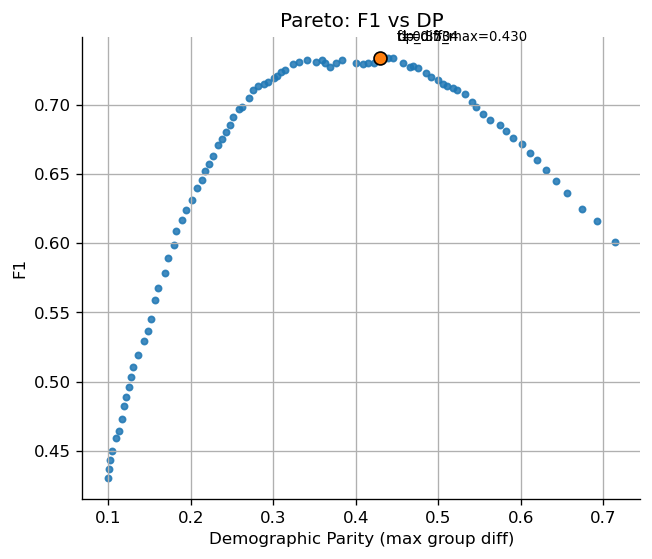

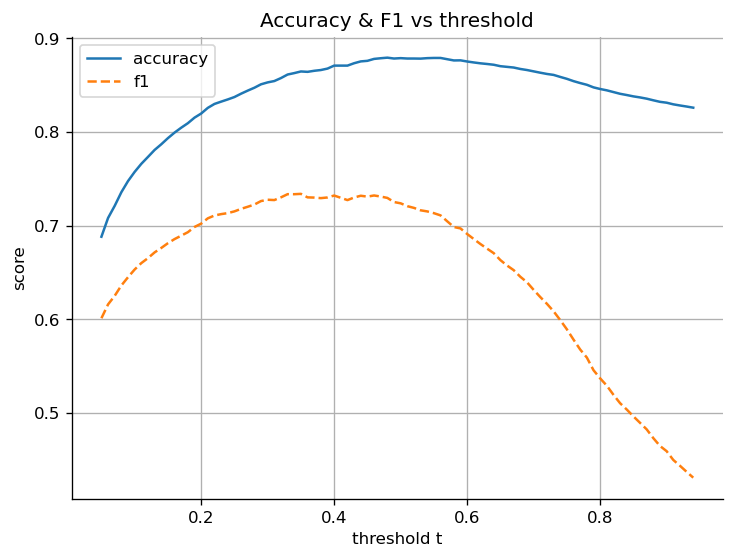

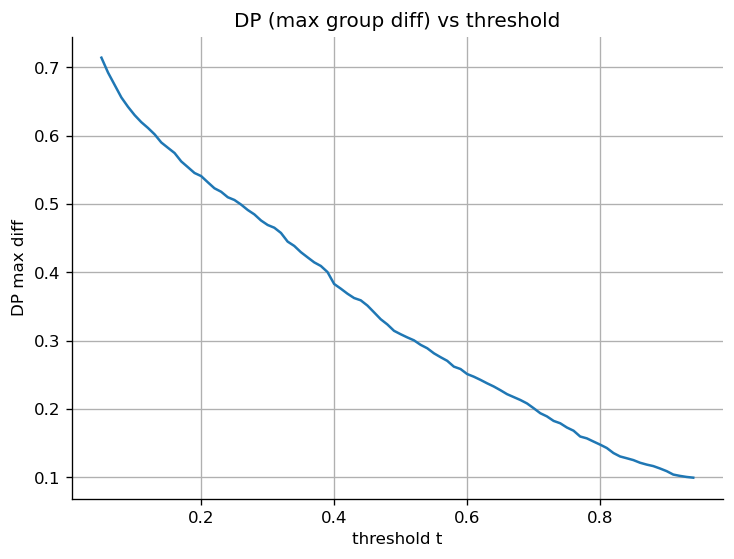

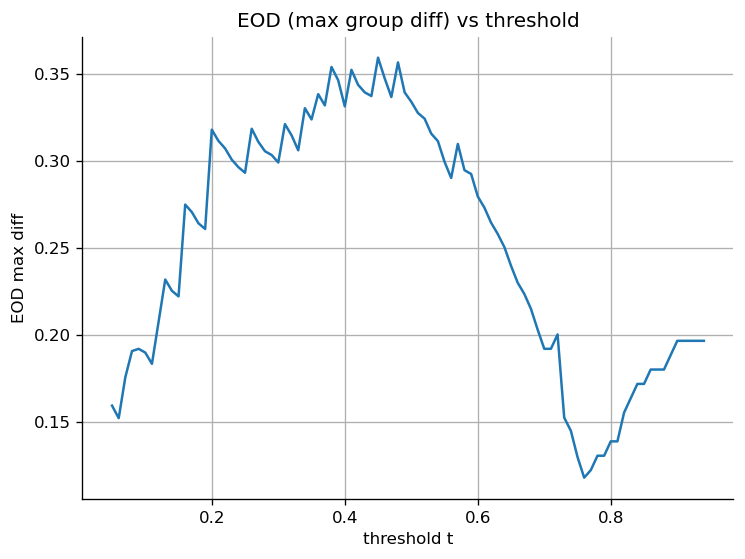

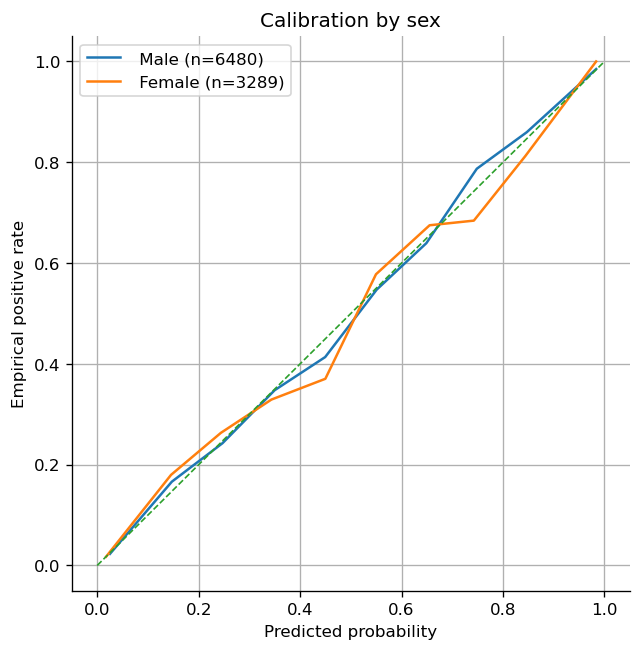

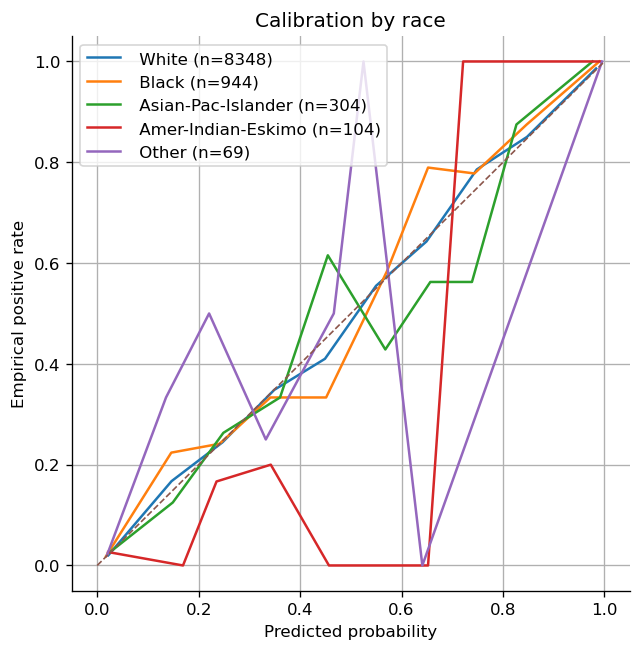

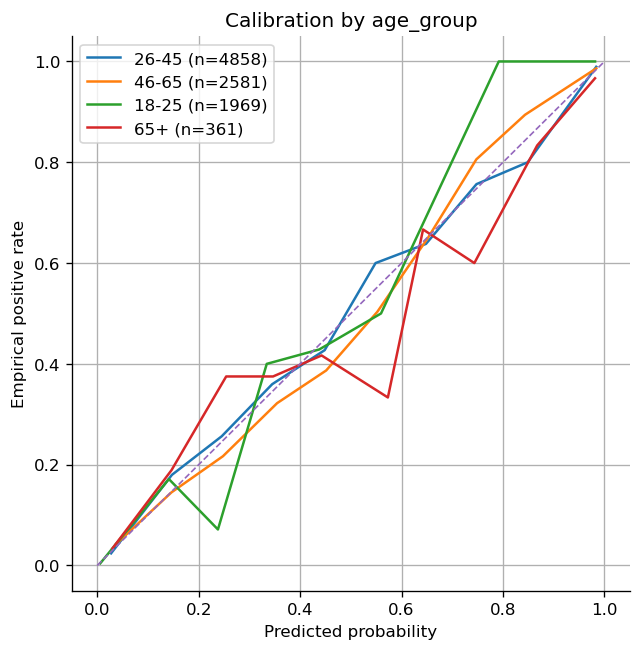

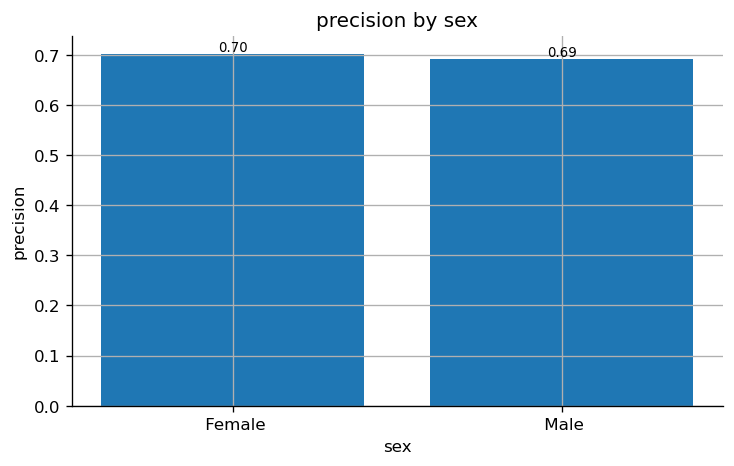

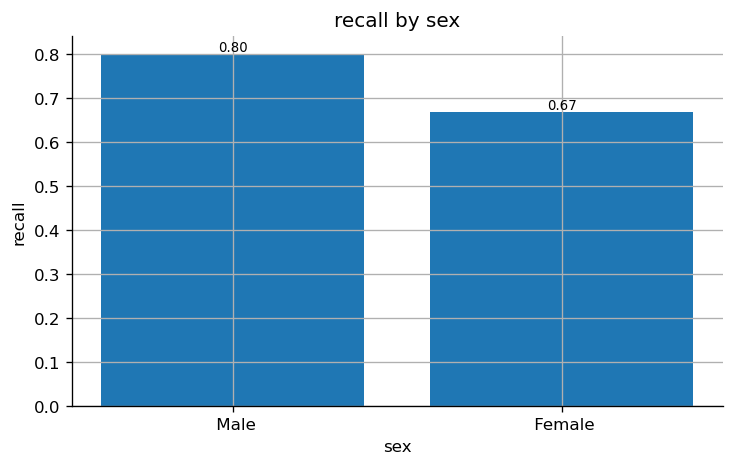

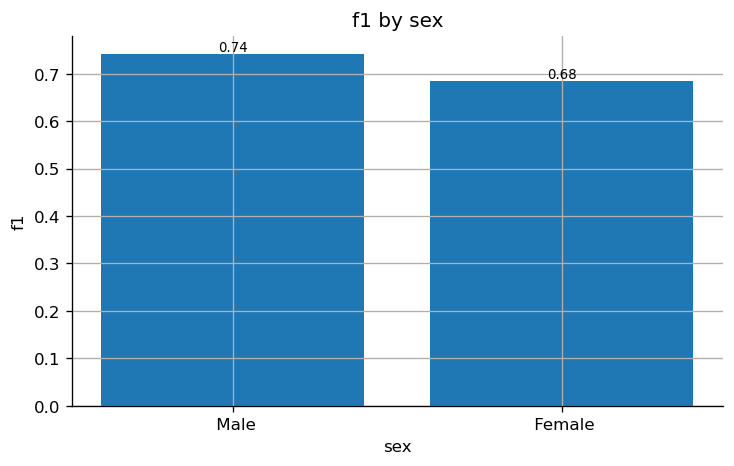

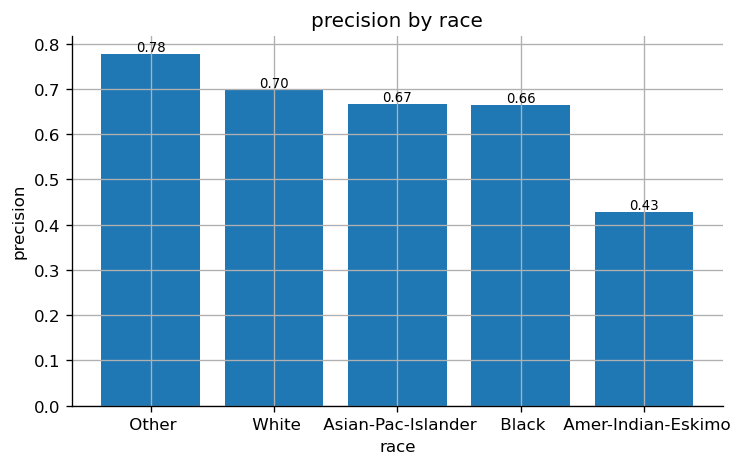

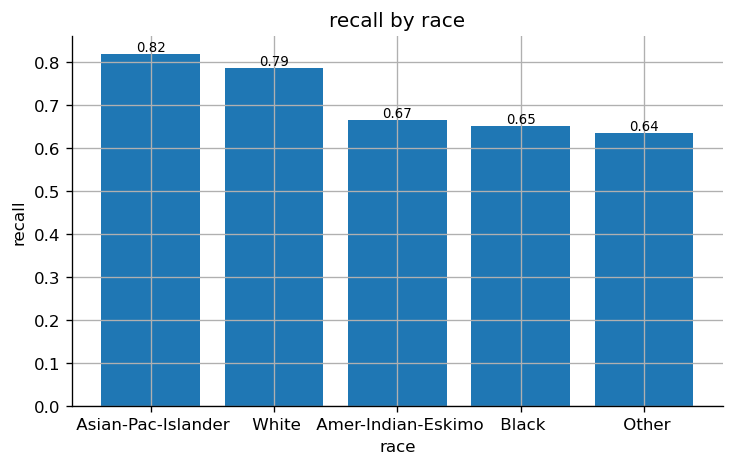

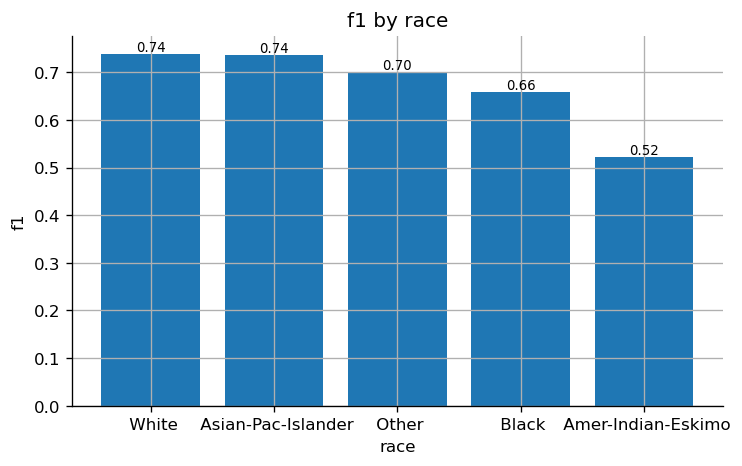

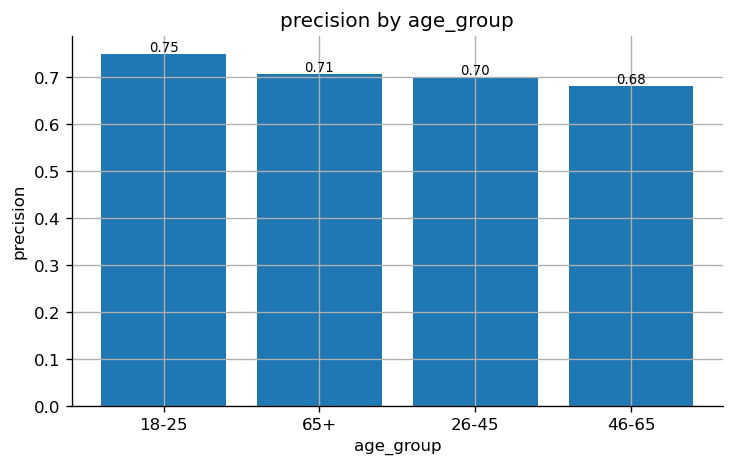

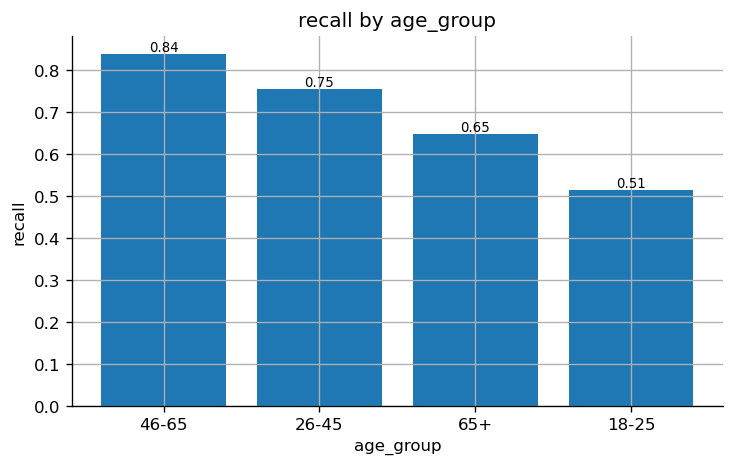

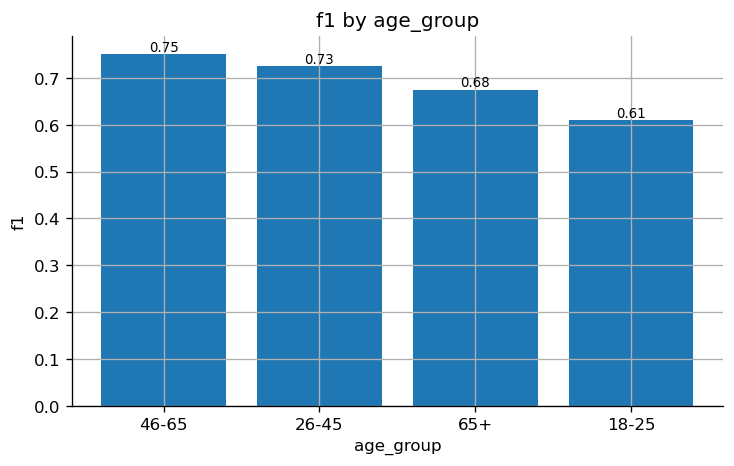

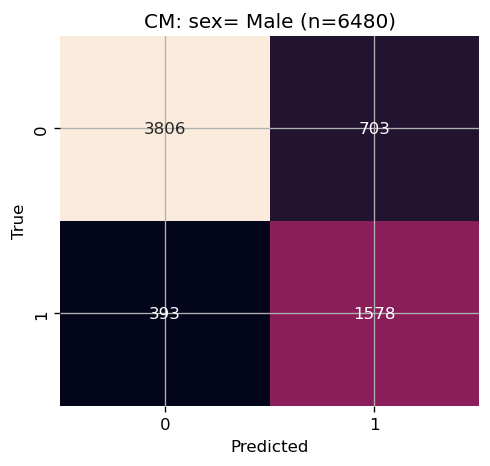

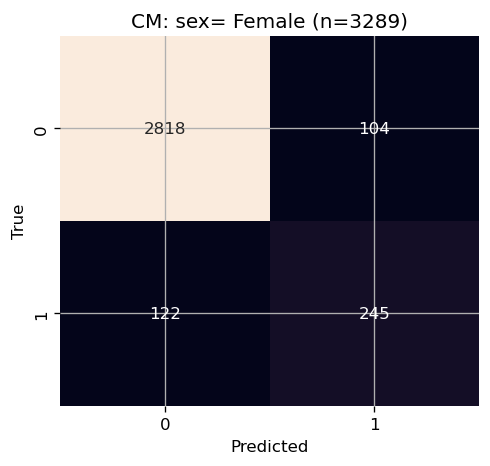

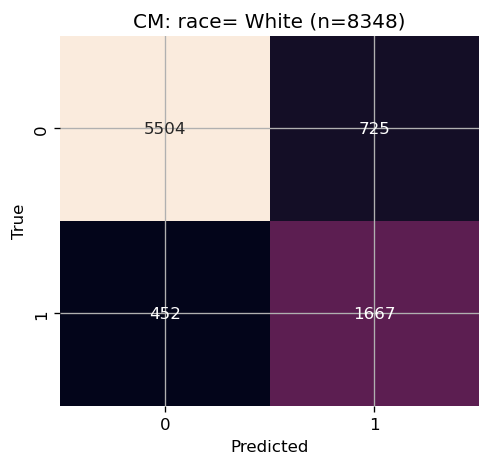

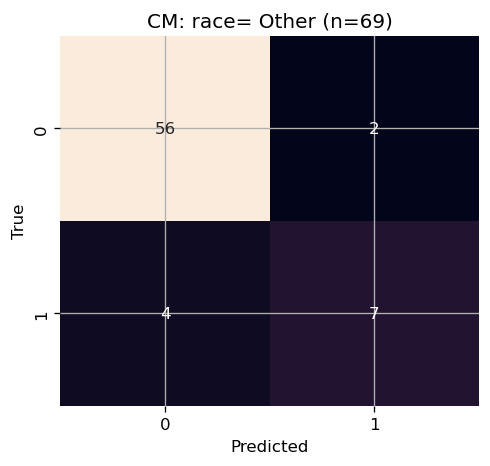

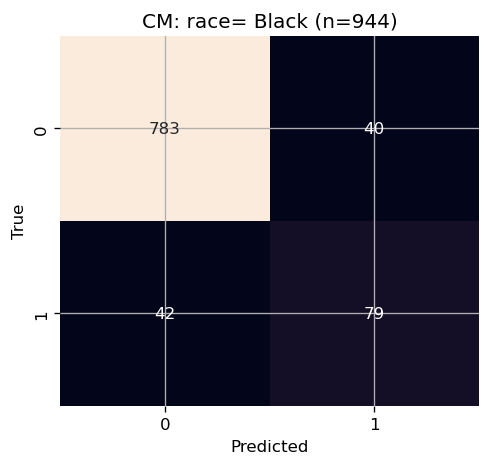

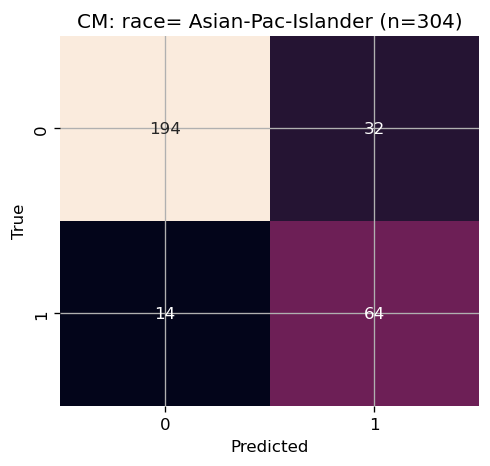

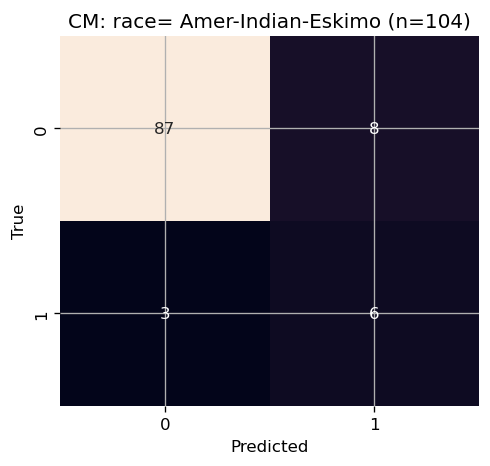

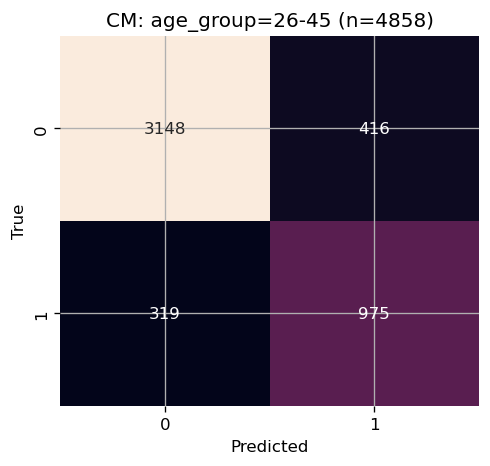

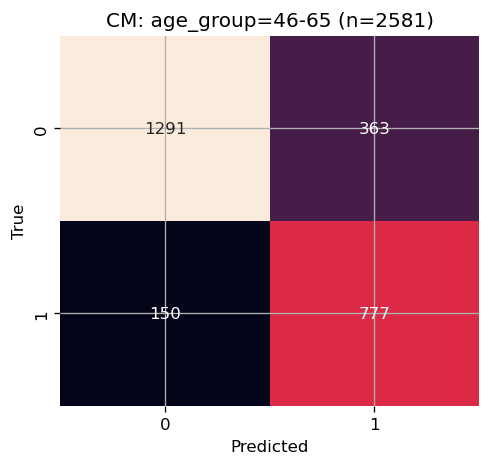

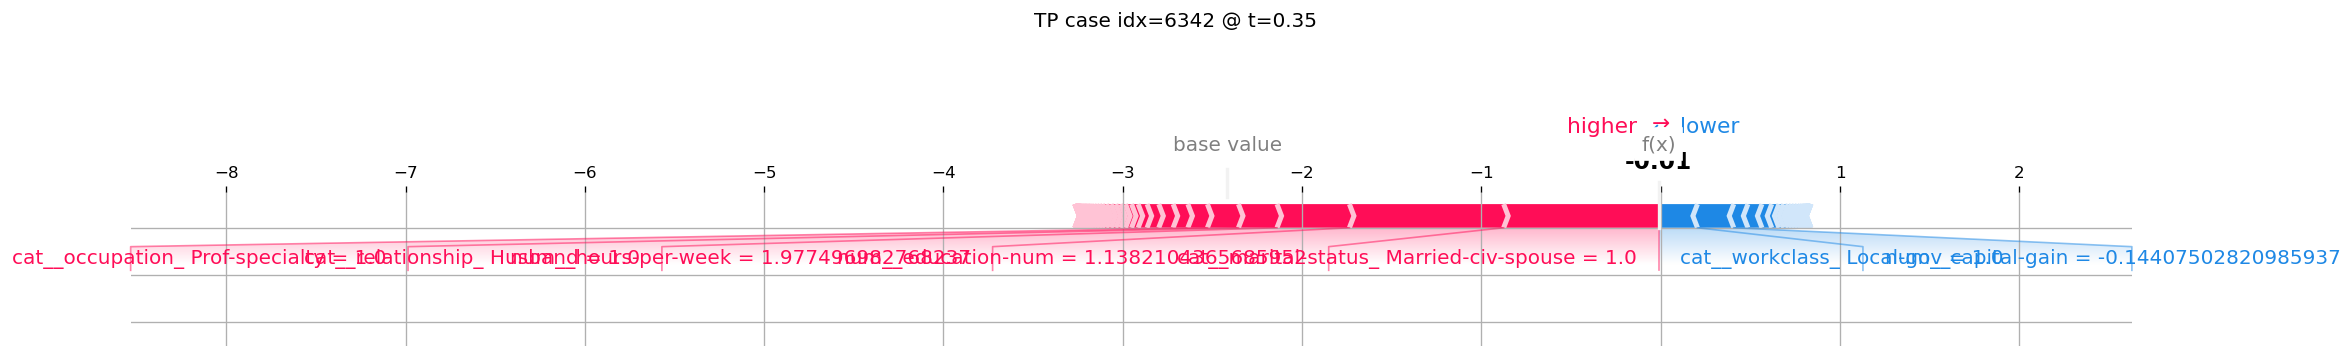

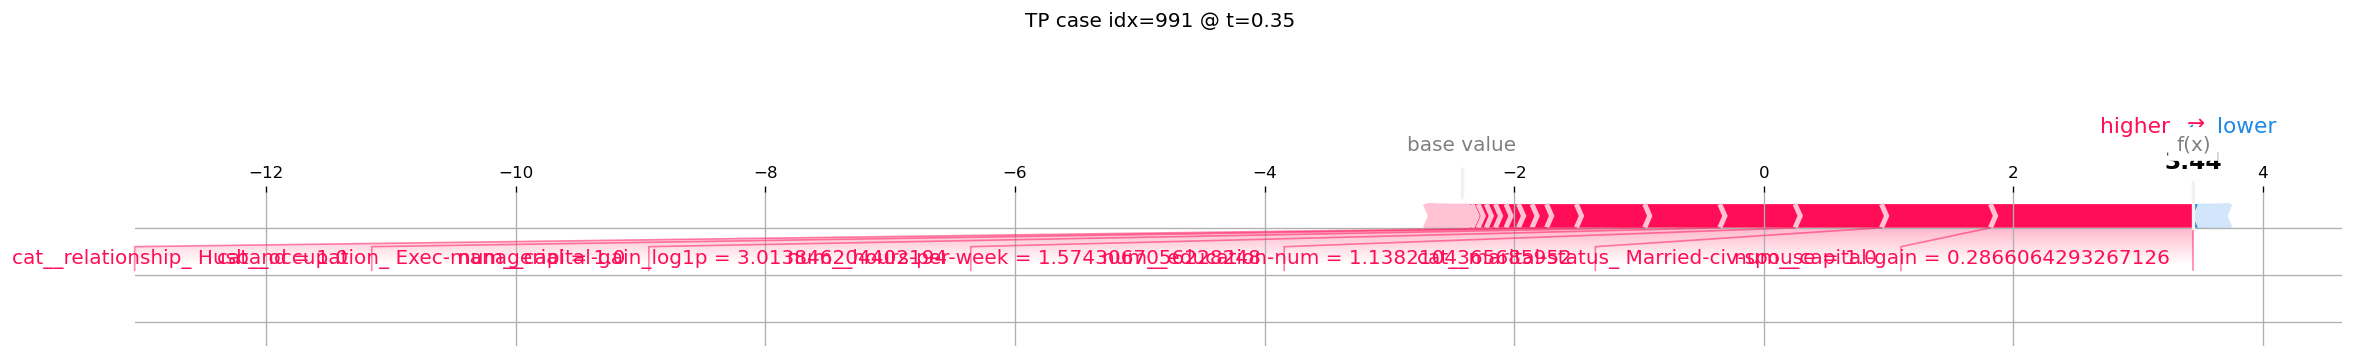

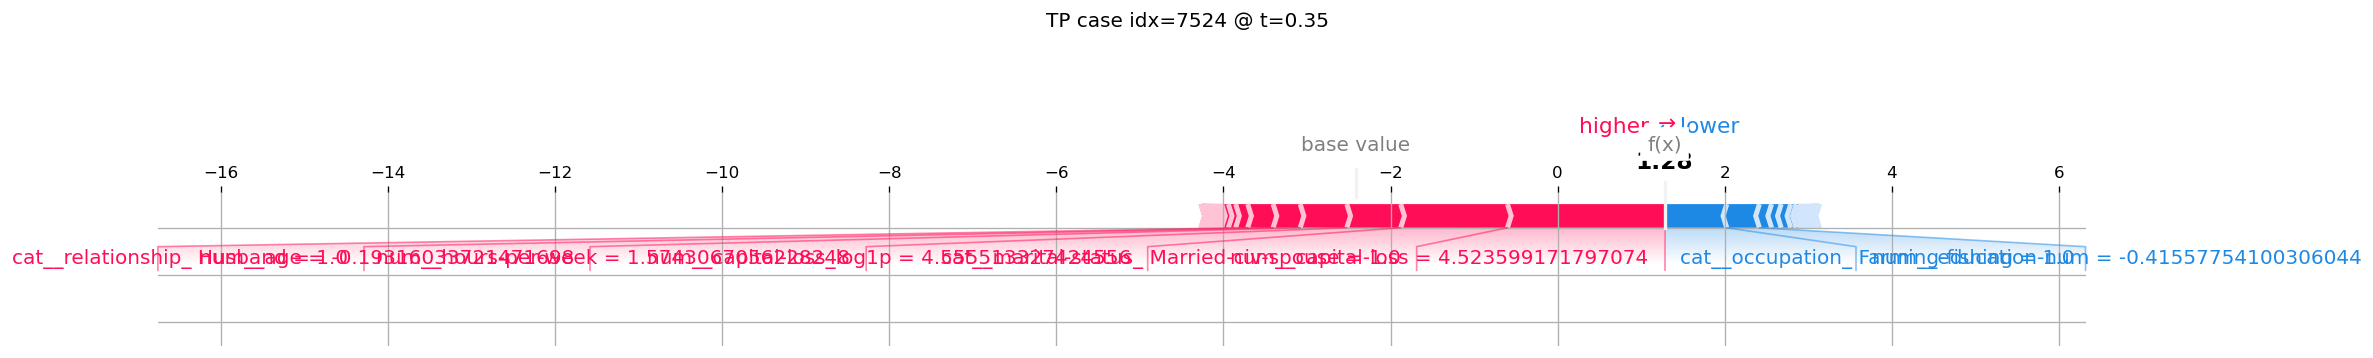

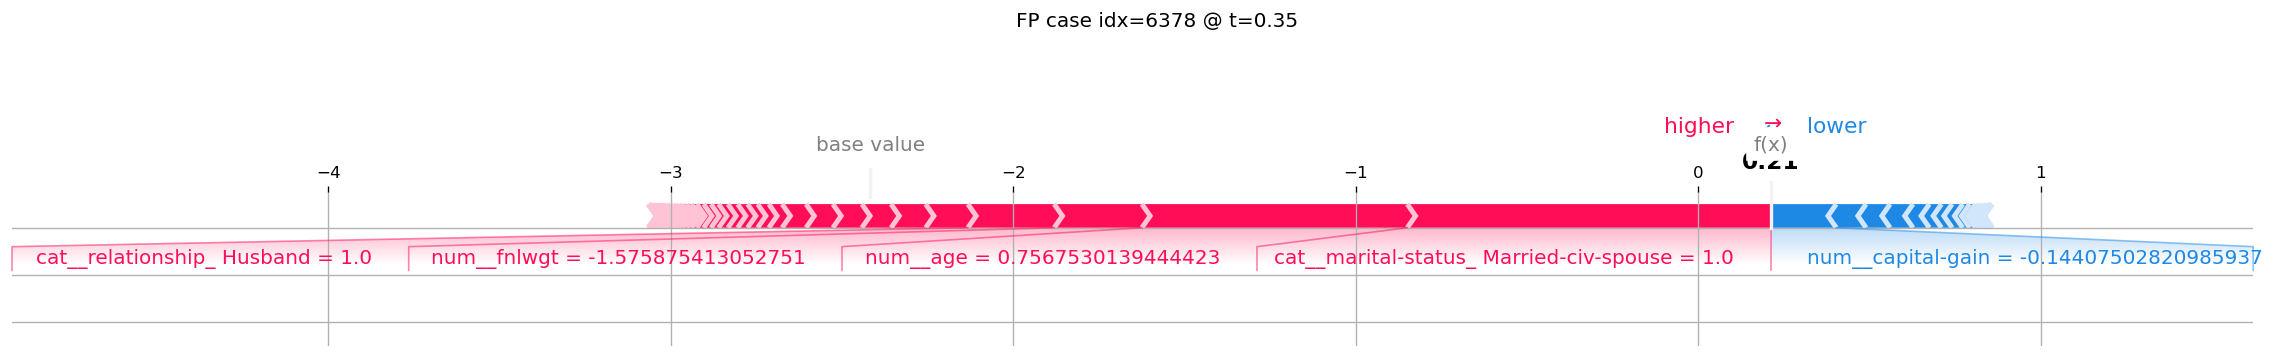

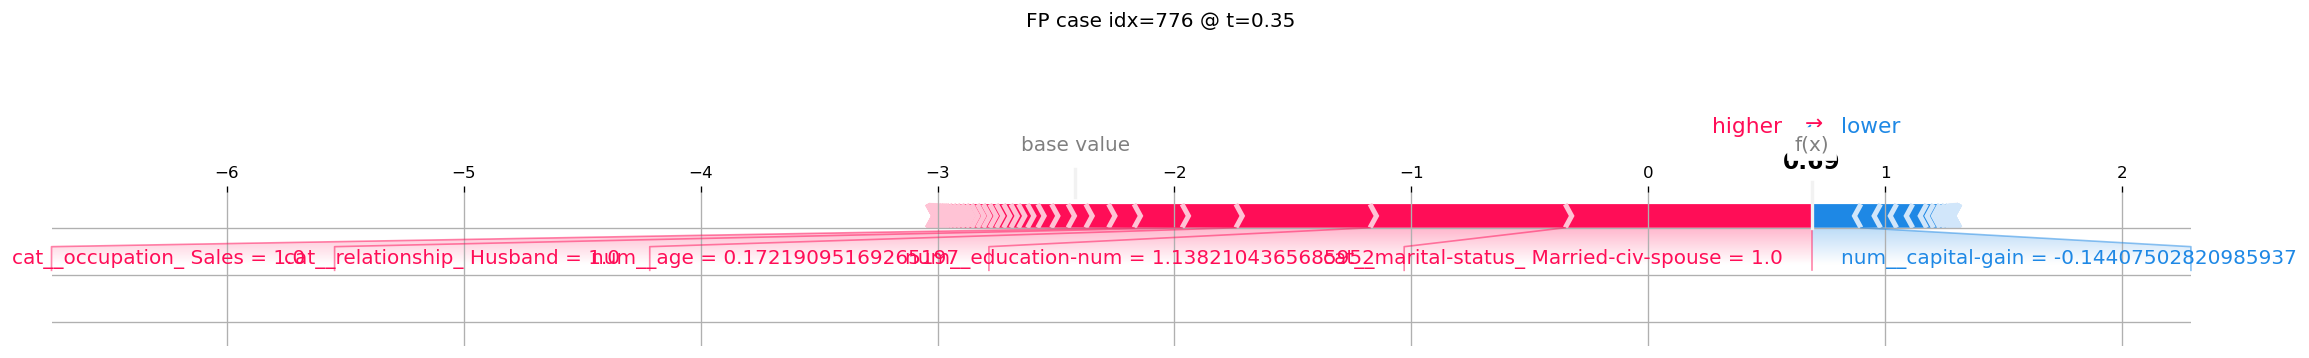

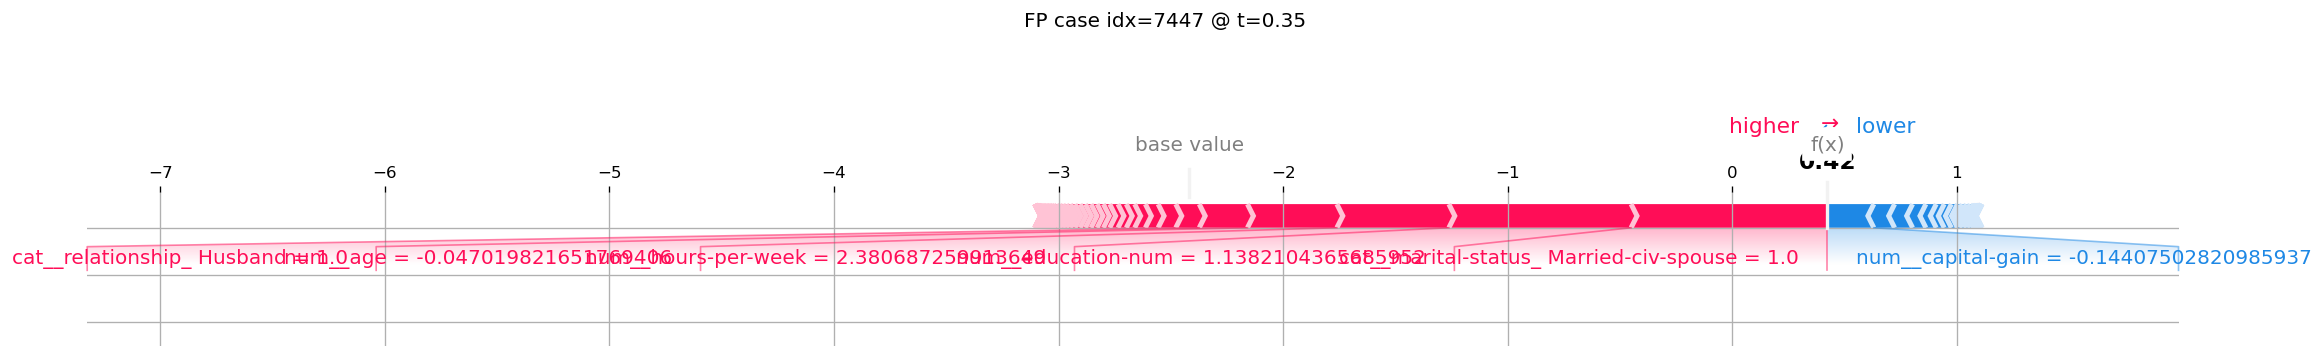

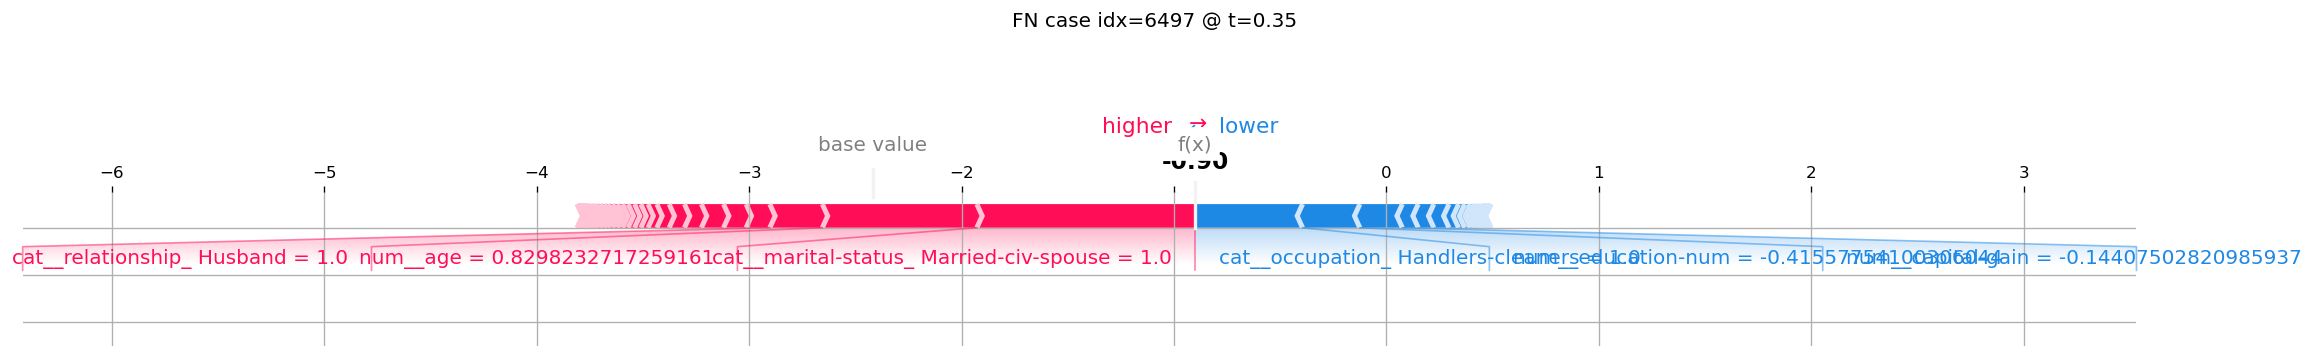

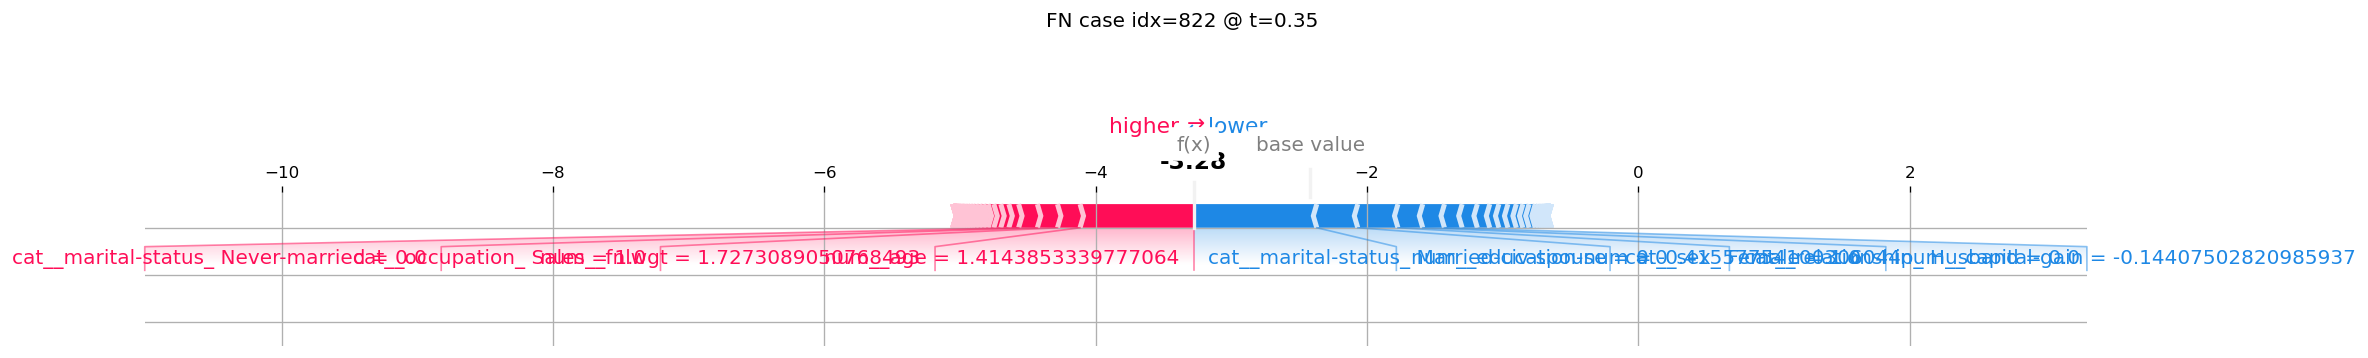

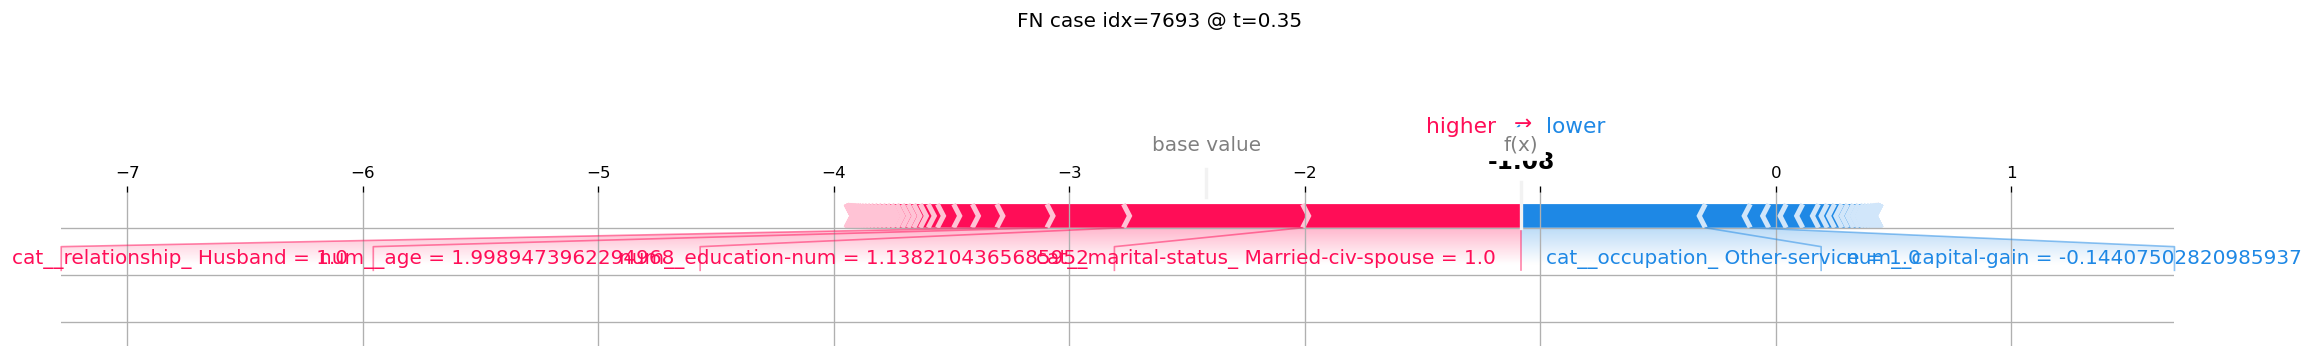

In [125]:
# --- Explainability: локально (кейсы TP/FP/FN) --- #

assert all(k in globals() for k in ['y_true_test', 'y_proba_best', 'X_test_sens'])
thr = globals().get('t_star', 0.5)
y_pred_thr = (y_proba_best >= thr).astype('int8')

TP_idx = np.where((y_true_test == 1) & (y_pred_thr == 1))[0]
FP_idx = np.where((y_true_test == 0) & (y_pred_thr == 1))[0]
FN_idx = np.where((y_true_test == 1) & (y_pred_thr == 0))[0]

# только артефакты из unified loader #
XS, _ = A['X_test_enc']
feature_names, _ = A['feature_names']
model, _ = A['model']

# извлечение классификатора из best_estimator_/Pipeline #
obj = getattr(model, 'best_estimator_', model)
if hasattr(obj, 'named_steps'):
    clf_for_shap = obj.named_steps.get('clf', None)
    if clf_for_shap is None:
        for step in obj.named_steps.values():
            if hasattr(step, 'predict_proba') or hasattr(step, 'predict'):
                clf_for_shap = step
                break
else:
    clf_for_shap = obj

if clf_for_shap is None:
    raise RuntimeError('Не удалось извлечь классификатор из Pipeline для SHAP.')

if XS is None and feature_names is None:
    raise RuntimeError('Нет X_test_enc или feature_names из артефактов; не выполняем explainability.')
    
# построение SHAP-графиков #
expl = shap.TreeExplainer(clf_for_shap)

def _pick_some(arr, k=3):
    if len(arr) == 0:
        return []
    rng = np.random.default_rng(42)
    return arr if len(arr) <= k else rng.choice(arr, size=k, replace=False).tolist()

cases = [
    ('TP', _pick_some(TP_idx, 3)),
    ('FP', _pick_some(FP_idx, 3)),
    ('FN', _pick_some(FN_idx, 3)),
]

for tag, idxs in cases:
    if not idxs:
        print(f'{tag}: нет кейсов - пропуск.')
        continue
    for i in idxs:
        if hasattr(XS, 'iloc'):
            row = XS.iloc[[i]]
        elif sp.issparse(XS):
            row = XS[i]
        else:
            row = XS[i:i+1]

        sv = expl.shap_values(row)

        # выбор класс и разжитие до 2D
        sv_arr = sv[1] if isinstance(sv, list) else sv
        if getattr(sv_arr, 'ndim', 1) == 1:
            sv_arr = sv_arr.reshape(1, -1)
        
        # LightGBM: последний столбец =  base value -> вынести и обрезать
        if sv_arr.shape[1] == row.shape[1] + 1:
            base_val = sv_arr[0, -1]
            sv_arr = sv_arr[:, :-1]
        else:
            ev = expl.expected_value
            base_val = ev[1] if isinstance(ev, (list, np.ndarray)) else ev
        
        # признаки как 1D
        if hasattr(row, 'values'):              # DataFrame
            feats_1d = row.values.reshape(-1)
        else:                                   # np/sparse
            feats_1d = np.asarray(row).reshape(-1)

        fig = shap.force_plot(
            base_value=base_val,
            shap_values=sv_arr.reshape(-1),
            features=feats_1d,
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.suptitle(f'{tag} case idx={i} @ t={thr:.2f}')
        plt.tight_layout()
        plt.show(fig)

# --- Риски, ограничения, рекомендации --- #

**Качество модели:**
1. Базовый порог t = 0.5: Accuracy ~0.878, F1 ~0.723, ROC-AUC ~0.89.
2. После оптимизации (ThresholdOptimizer DP) удалось сильно снизить разрыв по *'sex'* (dp_diff ~0.0012), но при этом немного просели F1/Accuracy.

**Справедливость:**
1. На базовом пороге t = 0.5 - значимый разрыв в selection rate (женщины в 3 раза реже получают положительный прогноз).
2. Пост-процессинг DP почти полностью выровнял группы, но с потерей качества.
3. EqOdds уменьшил разрыв по TPR/FPR, но не столь эффективно для общего dp_diff.

**Калибровка:**
1. Для больших групп (*'sex'*, *'White'*, *'26-45 лет'*) - отличная (ECE < 0.02).
2. Для малых групп (*'Other race'*, *'Amer-Indian-Eskimo'*, *'65+'*) - калибровка хуже, вероятности "рваные" из-за малого числа наблюдений.
3. Рекомендация: дополнительно проверить калибровку на валидации, возможно применить Platt/Isotonic для крупных групп.

**Интерпретируемость (SHAP):**
1. Важнейшие признаки: *'marital-status_Married-civ-spouse'*, *'age'*, *'education-num'*, *'capital-gain'*, *'hours-per-week'*.
2. Чувствительные признаки (*'sex'*, *'race'*, *'age_group'*) имеют малое среднее влияние - модель напрямую их почти не использует.
3. Но косвенное влияние (через *'marital-status'*, *'occupation'*) возможно.

**Риски и ограничения:**
1. Малые подгруппы -> нестабильные метрики, риски переобучения при перекалибровке.
2. Баланс fairness/accuracy: при сильной коррекции fairness (DP/EqOdds) качество заметно падает.
3. Возможные прокси-признаки (семейное положение, профессия) могут неявно кодировать пол/возраст.

**Рекомендации:**
1. Для продуктивного использования модель - оставлять *'t = 0.5'* или *'t*'* как базовый вариант.
2. Для задач, где fairness критичен - рассмотреть ThresholdOptimizer (DP).
3. Пересобрать фичи: убрать/агрегировать потенциальные прокси, проверить, как это влияет на fairness.
4. Дособрать данные по малым группам (особенно по расам и возрасту 65+).
5. Рассмотреть групповую калибровку для основных чувствительных переменных.

In [126]:
# --- Экспорт артефактов из 03_fairness_and_explainability.ipynb --- #

ART_DIR = globals().get('ART_DIR', Path('data') / 'artifacts')
REPORTS_DIR = globals().get('REPORTS_DIR', Path('data') / 'reports')

ART_DIR.mkdir(parents=True, exist_ok=True)
(REPORTS_DIR / 'figures_03').mkdir(parents=True, exist_ok=True)

# экспорт сканирования порогов #
scan_obj = globals().get('scan_df', None)
try:
    if isinstance(scan_obj, pd.DataFrame) and len(scan_obj) > 0:
        out_csv = ART_DIR / 'fairness_threshold_scan.csv'
        scan_obj.to_csv(out_csv, index=False)
        print(f'Saved fairness_threshold_scan.csv -> {out_csv}')

        # копия в reports для удобства просмотра
        out_csv_rep = (REPORTS_DIR / 'figures_03' / 'fairness_threshold_scan.csv')
        try:
            scan_obj.to_csv(out_csv_rep, index=False)
            print(f'Copied to reports -> {out_csv_rep}')
        except Exception as e:
            print('[warn] copy to reports failed:', e)
    else:
        print('[info] scan_df отсутствует или пуст - экспорт пропущен.')
except Exception as e:
    print('[warn] scan_df export:', e)

print('Экспорт артефактов из 03_fairness_and_explainability.ipynb завершен.')

Saved fairness_threshold_scan.csv -> c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\artifacts\fairness_threshold_scan.csv
Copied to reports -> C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03\fairness_threshold_scan.csv
Экспорт артефактов из 03_fairness_and_explainability.ipynb завершен.


In [127]:
# --- Контроль готовности --- #

# базовые директории #
ROOT = globals().get('ROOT', Path('.'))
ART_DIR = globals().get('ART_DIR', ROOT / 'data' / 'artifacts')
REPORTS_DIR = globals().get('REPORTS_DIR', ROOT / 'data' / 'reports')
FIG_DIR_03 = REPORTS_DIR / 'figures_03'

# проверка наличия ключевых директорий #
assert ART_DIR.exists(), f'Нет папки артефактов: {ART_DIR}'
FIG_DIR_03.mkdir(parents=True, exist_ok=True)

# обязательные объекты в памяти #
need = ['feature_names', 'X_test_enc', 'sensitive', 'y_true', 'y_proba', 'y_pred']
miss = [k for k in need if (k not in A) or (A.get(k, (None, None))[0] is None)]
if miss:
    raise RuntimeError(f'Не загружены артефакты {miss}')

# ожидаемые файлы и паттерны #
critical = [
    FIG_DIR_03 / 'fairness_threshold_scan.csv',
    ART_DIR / 'fairness_threshold_scan.csv',
    FIG_DIR_03 / 'shap_summary_top10.png',
    FIG_DIR_03 / 'shap_bar_top10.png',
    FIG_DIR_03 / 'group_metrics_t_star.csv',
    FIG_DIR_03 / 'selection_rates_t_star.csv',
]

patterns = [
    'Pareto_f1_vs_dp.png',
    'accuracy_f1_vs_threshold.png',
    'dp_vs_threshold.png',
    'eod_vs_threshold.png',
    'calibration_*.png',
    'bar_precision_by_*.png',
    'bar_recall_by_*.png',
    'bar_f1_by_*.png',
    'cm_*_*.png',
]

# проверка critical #
missing_critical = [str(p) for p in critical if not Path(p).exists()]
if missing_critical:
    raise AssertionError(f'Отсутствуют обязательные файлы: {missing_critical}')

# сводка по паттернам #
summary = {}
for pat in patterns:
    files = list(FIG_DIR_03.glob(pat))
    summary[pat] = len(files)

# печать сводки #
print('[fairness] report @', FIG_DIR_03)
for pat, cnt in summary.items():
    print(f'    {pat:28s} -> {cnt:3d}')

# дополнительная логика: предупреждения #
warn = []

# если есть чувствительные признаки, ожидаем как минимум по одному графику var_*
_sens_df = A.get('sensitive', (globals().get('X_test_sensitive', None), None))[0]
present_cols = [c for c in ['sex', 'race', 'age_group'] if (_sens_df is not None and c in _sens_df.columns)]
for col in present_cols:
    for base in ['bar_precision_by_', 'bar_recall_by_', 'bar_f1_by_']:
        if not list(FIG_DIR_03.glob(f'{base}{col}.png')):
            warn.append(f'Нет {base}{col}.png')

# хотя бы одна матрица ошибок
if summary.get('cm_*_*.png', 0) == 0:
    warn.append('Нет confusion matrices (cm_*_*.png)')

# хотя бы один calibration_*.png #
if summary.get('calibration_*.png', 0) == 0:
    warn.append('Нет calibartion_*.png')

if warn:
    print('[fairness][warn]', '; '.join(warn))
else:
    print('[fairness] OK: полный набор файлов сформирован.')

[fairness] report @ C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\data\reports\figures_03
    Pareto_f1_vs_dp.png          ->   1
    accuracy_f1_vs_threshold.png ->   1
    dp_vs_threshold.png          ->   1
    eod_vs_threshold.png         ->   1
    calibration_*.png            ->   3
    bar_precision_by_*.png       ->   3
    bar_recall_by_*.png          ->   3
    bar_f1_by_*.png              ->   3
    cm_*_*.png                   ->  11
[fairness] OK: полный набор файлов сформирован.
